In [1]:
# initiation 12/26/2023

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import constrNMPy
import os 
from matplotlib import gridspec
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

# os.getcwd() 
# # change the working directory to the folder where the data is stored

# color pallette
[gr,ye,re,bl,pu,ir,ak] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']
[vio, grb, lig, sil, aqua] = ['#8c84cf','#6699CC','#66CC99','#C0C0C0','#6db3bc']

# set the style of the plots
az.style.use("arviz-white")
# set the text font to be Arial
plt.rcParams['font.sans-serif'] = "Arial"


# 1 Data Loading and Preprocessing

Download data from Github.

Format: Columns: **"#_Qx_xxxxx#**
- *Q1_First Click*: timestamp for first click
- *Q1_Last Click*: timestamp for last click
- *Q1_Page Submit*: timestamp for submitting this page
- *Q1_Click Count*: total click times for thhis page
- *Q2*: Response Choice (1: Correct, 2: Incorrect)
- *Q3_1*: Confidence Rating (from 50 to 100)

In [2]:
url = 'https://raw.githubusercontent.com/AbelZheng/NeuroEcon/main/SCM_Data_no_info.csv'
all_data = pd.read_csv(url)
all_data = all_data.drop(['Unnamed: 0'], axis=1)
all_data.head()

,1_Q1_First Click,1_Q1_Last Click,1_Q1_Page Submit,1_Q1_Click Count,1_Q2,1_Q3_1,2_Q1_First Click,2_Q1_Last Click,2_Q1_Page Submit,2_Q1_Click Count,...,82_Q1_Page Submit,82_Q1_Click Count,82_Q2,82_Q3_1,83_Q1_First Click,83_Q1_Last Click,83_Q1_Page Submit,83_Q1_Click Count,83_Q2,83_Q3_1
0,1.104,2.126,2.442,2,1,100,2.541,3.277,3.664,2,...,8.388,2,2,73,1.396,4.119,4.372,4,1,100
1,3.196,3.933,5.193,2,1,51,2.619,3.898,4.198,3,...,5.160,2,2,87,6.175,6.957,7.535,2,1,83
2,1.365,2.687,3.438,2,1,100,3.313,5.564,6.474,3,...,6.618,2,1,74,3.924,5.003,6.323,2,1,100
3,1.459,2.647,3.641,3,1,100,2.967,4.101,4.700,3,...,5.248,5,2,97,2.766,3.850,4.717,2,1,100
4,2.173,4.885,5.344,3,1,52,2.818,4.383,8.206,2,...,7.052,2,2,55,7.033,43.480,54.424,4,1,100


In [3]:
# Arrange the Columns:
total_question_number = 83
Qidx = np.arange(1, total_question_number+1)
subfixes  = ['Q1_FistClick', 'Q1_LastClick', 'Q1_PageSubmit', 'Q1_ClickCount', 'Q2','Q3_1']

# Extract Responses For All Questions
Response_Acc_All = pd.DataFrame()
Response_Confi_All = pd.DataFrame()
RT_All = pd.DataFrame()

Response_Acc_Mean = []
Response_Acc_SD = []
Response_Confi_Mean = []
Response_Confi_SD = []
for i in range(1, total_question_number+1):
    Response = all_data['{}_{}'.format(i, 'Q2')]
    Response.replace(2, 0, inplace=True)
    Response_Acc_All = pd.concat([Response_Acc_All, Response], axis=1)
    Response_Confi = all_data['{}_{}'.format(i, 'Q3_1')]
    Response_Confi_All = pd.concat([Response_Confi_All, Response_Confi], axis=1)
    RT = all_data['{}_{}'.format(i, 'Q1_Page Submit')]
    RT_All = pd.concat([RT_All, RT], axis=1)
    
    Response_Acc_Mean.append(Response.mean())
    Response_Acc_SD.append(Response.std())
    Response_Confi_Mean.append(Response_Confi.mean())
    Response_Confi_SD.append(Response_Confi.std())
    
# Rename the columns to 'Q{}' format
Response_Acc_All.columns = ['Q{}'.format(i) for i in range(1, total_question_number+1)]
Response_Confi_All.columns = ['Q{}'.format(i) for i in range(1, total_question_number+1)]
RT_All.columns = ['Q{}'.format(i) for i in range(1, total_question_number+1)]

## 1.1 Screening: Outliers in Accuracy and Confidence

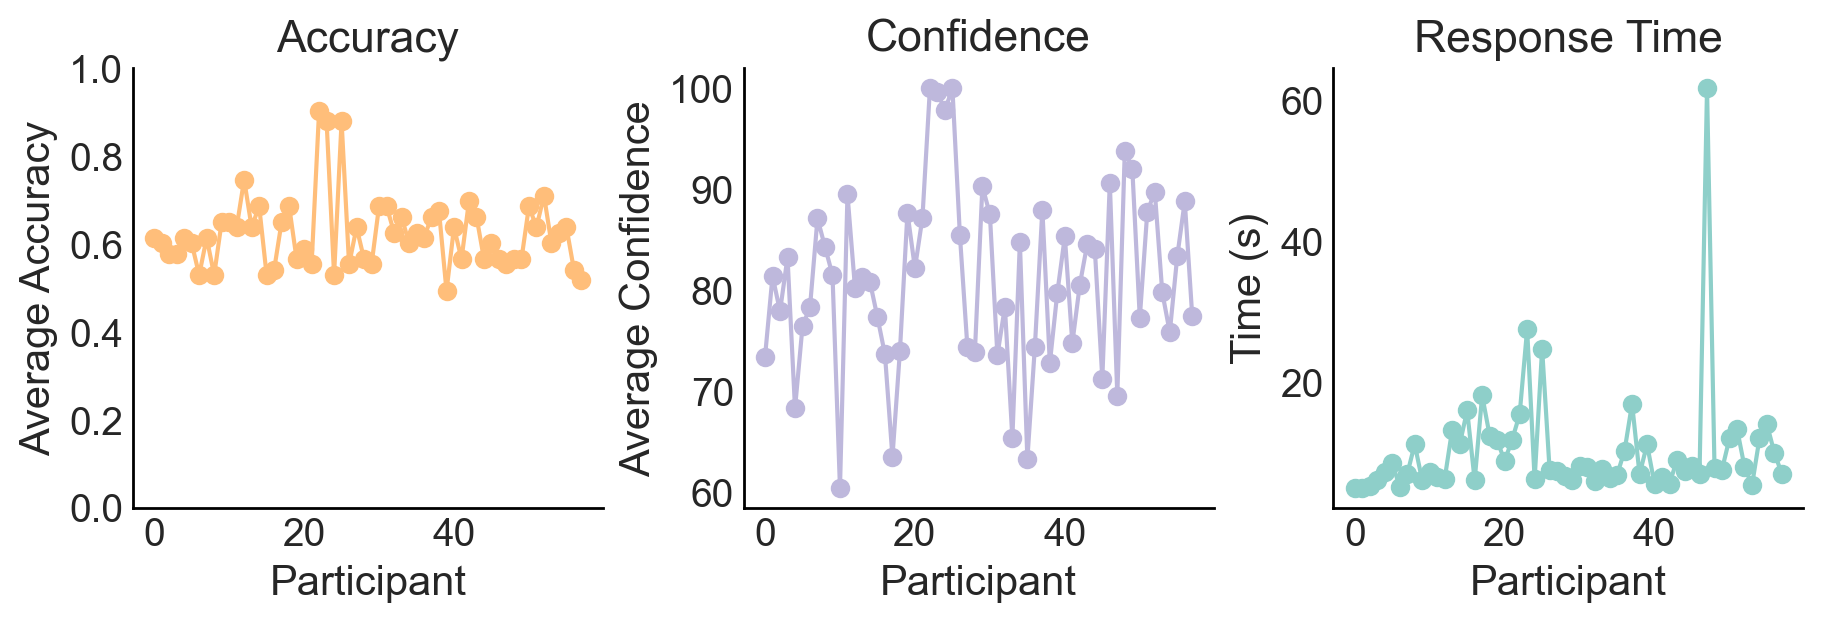

In [4]:
# Draw each participant's average accuracy and confidence

fig, ax = plt.subplots(1, 3, figsize=(9,3))
ax[0].plot(Response_Acc_All.mean(axis=1), 'o-', color=ye)
ax[0].set_xlabel('Participant')
ax[0].set_ylabel('Average Accuracy')
ax[0].set_ylim([0, 1])
ax[0].set_title('Accuracy')
ax[1].plot(Response_Confi_All.mean(axis=1), 'o-', color=pu)
ax[1].set_xlabel('Participant')
ax[1].set_ylabel('Average Confidence')
ax[1].set_title('Confidence')
ax[2].plot(RT_All.mean(axis=1), 'o-', color=gr)
ax[2].set_xlabel('Participant')
ax[2].set_ylabel('Time (s)')
ax[2].set_title('Response Time')
plt.tight_layout()
plt.show()

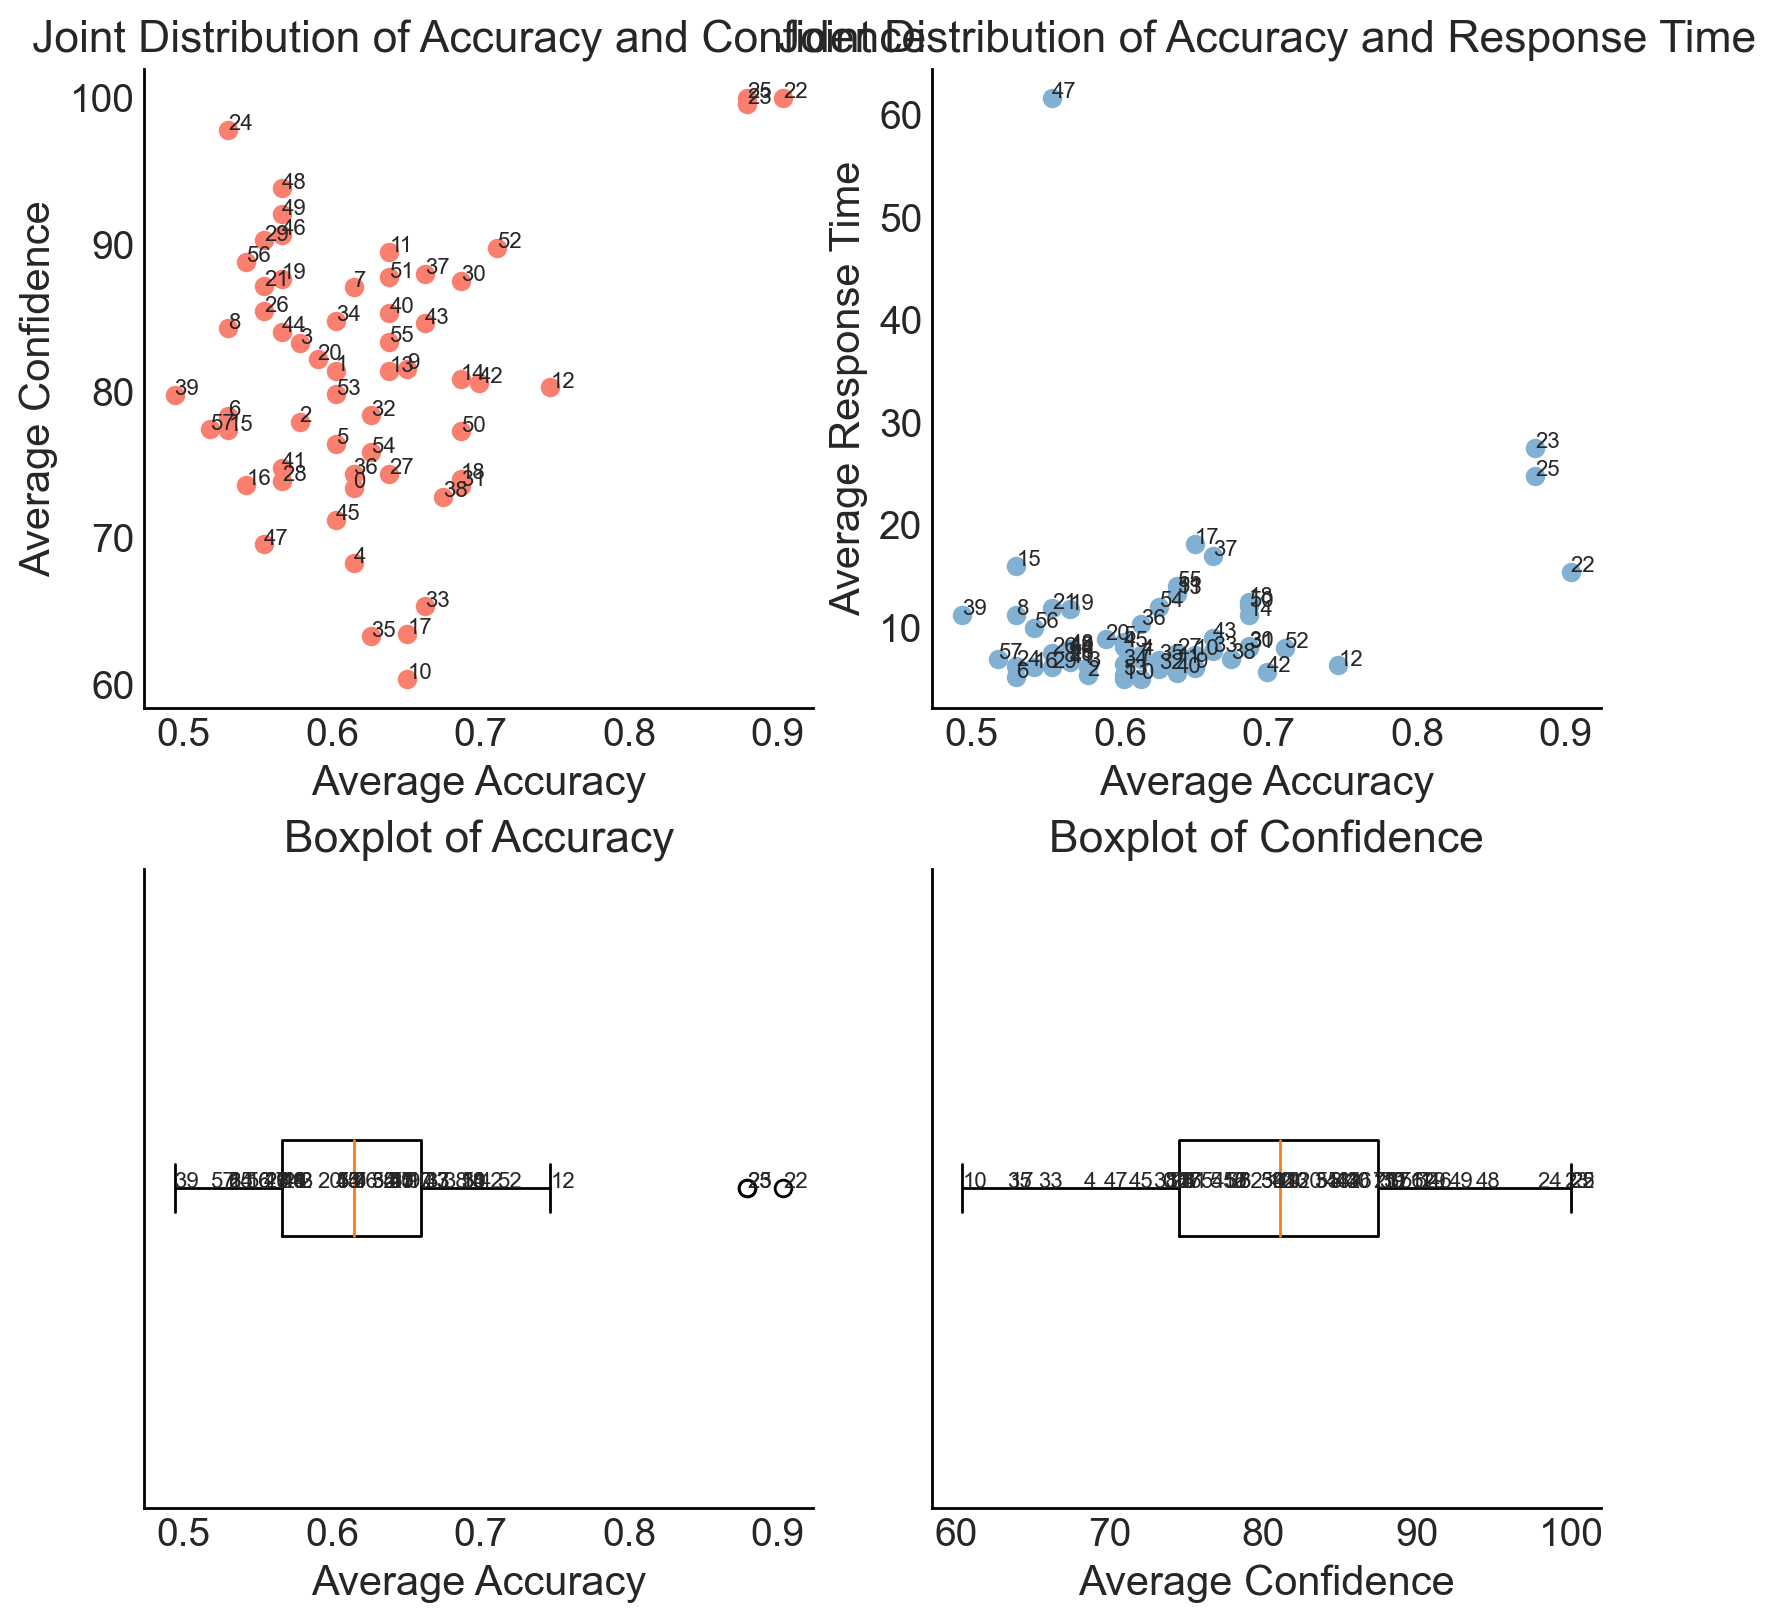

In [5]:
# If confidence and accuracy(ability) are correlated
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.title('Joint Distribution of Accuracy and Confidence')
plt.plot(Response_Acc_All.mean(axis=1), Response_Confi_All.mean(axis=1), 'o', color=re)
# Add participant ID labels
for i, participant_id in enumerate(Response_Acc_All.index):
    plt.text(Response_Acc_All.mean(axis=1)[i], Response_Confi_All.mean(axis=1)[i], participant_id, fontsize=8)
plt.xlabel('Average Accuracy')
plt.ylabel('Average Confidence')

# joint distribution of accuracy and response time
plt.subplot(2, 2, 2)
plt.title('Joint Distribution of Accuracy and Response Time')
plt.plot(Response_Acc_All.mean(axis=1), RT_All.mean(axis=1), 'o', color = bl)
# Add participant ID labels
for i, participant_id in enumerate(Response_Acc_All.index):
    plt.text(Response_Acc_All.mean(axis=1)[i], RT_All.mean(axis=1)[i], participant_id, fontsize=8)
plt.xlabel('Average Accuracy')
plt.ylabel('Average Response Time')

# boxplot and label for accuracy
plt.subplot(2, 2, 3)
plt.title('Boxplot of Accuracy')
plt.boxplot(Response_Acc_All.mean(axis=1), vert=False)
plt.xlabel('Average Accuracy')
plt.yticks([])
for i, participant_id in enumerate(Response_Acc_All.index):
    plt.text(Response_Acc_All.mean(axis=1)[i], 1, participant_id, fontsize=8)

# boxplot and label for confidence
plt.subplot(2, 2, 4)
plt.title('Boxplot of Confidence')
plt.boxplot(Response_Confi_All.mean(axis=1), vert=False)
plt.xlabel('Average Confidence')
plt.yticks([])
for i, participant_id in enumerate(Response_Acc_All.index):
    plt.text(Response_Confi_All.mean(axis=1)[i], 1, participant_id, fontsize=8)

plt.show()


In [6]:
All_Subj_Confi =  Response_Confi_All.mean(axis=1)
find_idx = np.where(All_Subj_Confi == 100)[0]
# subj 23 also seems to be an outlier
find_idx = np.append(find_idx, 23)
# subj 47 has extremely long response time
find_idx = np.append(find_idx, 47)
print(find_idx)

[22 25 23 47]


The results exhibit that, the population's performance and confidence both seem to have a normal distribution. 

However, there are some outliers in both accuracy and confidence. We will remove these outliers in the following analysis: Subj 22 23 25.

The average time spent for each question appears to be similar for all participants, except for Subj 47 with a much longer time spent, which is also excluded from the following analysis.

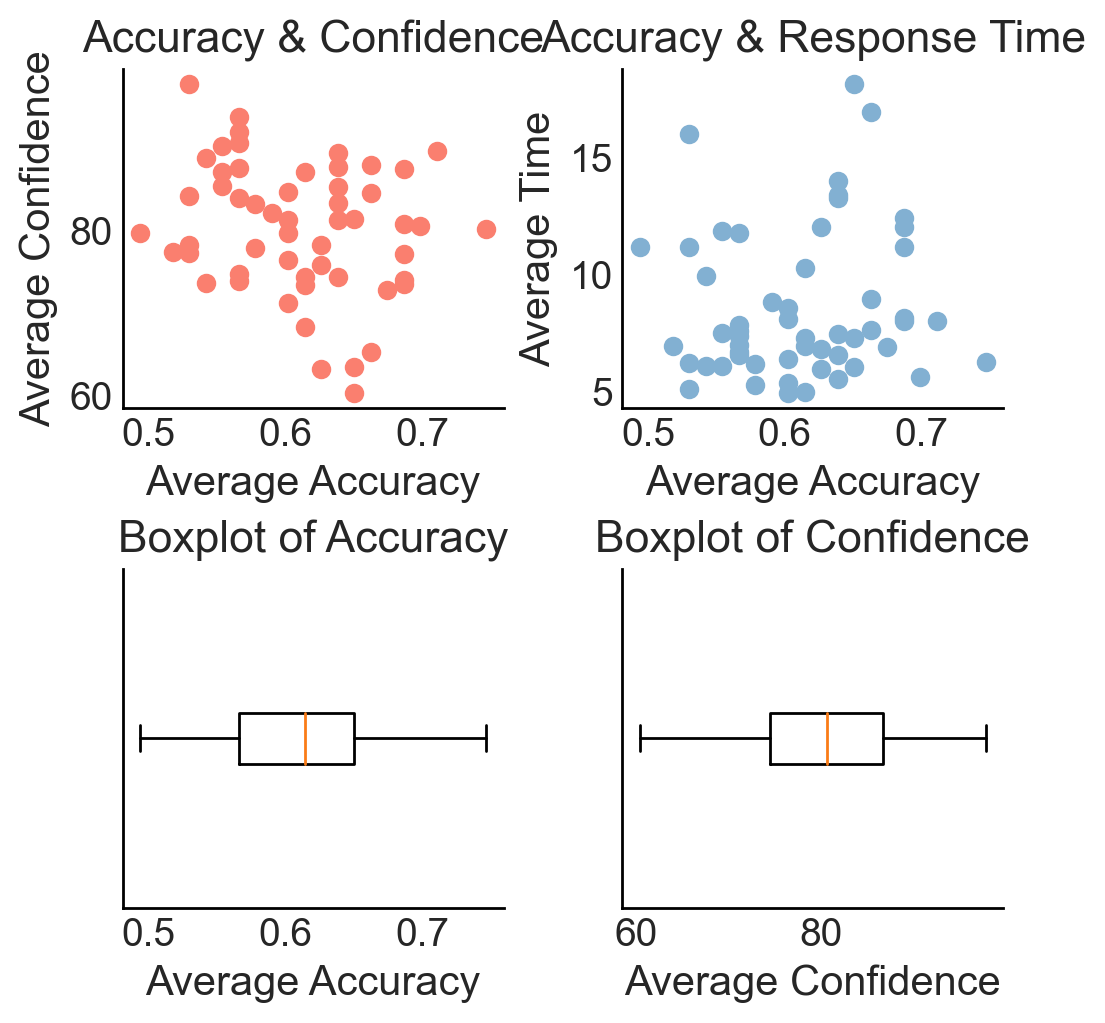

In [7]:
Response_Acc_All = Response_Acc_All.drop(find_idx)
Response_Confi_All = Response_Confi_All.drop(find_idx)
RT_All = RT_All.drop(find_idx)

# If confidence and accuracy(ability) are correlated
plt.figure(figsize=(5, 5))
plt.subplot(2, 2, 1)
plt.title('Accuracy & Confidence')
plt.plot(Response_Acc_All.mean(axis=1), Response_Confi_All.mean(axis=1), 'o', color=re)
plt.xlabel('Average Accuracy')
plt.ylabel('Average Confidence')

# joint distribution of accuracy and response time
plt.subplot(2, 2, 2)
plt.title('Accuracy & Response Time')
plt.plot(Response_Acc_All.mean(axis=1), RT_All.mean(axis=1), 'o', color = bl)
plt.xlabel('Average Accuracy')
plt.ylabel('Average Time')

# boxplot and label for accuracy
plt.subplot(2, 2, 3)
plt.title('Boxplot of Accuracy')
plt.boxplot(Response_Acc_All.mean(axis=1), vert=False)
plt.xlabel('Average Accuracy')
plt.yticks([])

# boxplot and label for confidence
plt.subplot(2, 2, 4)
plt.title('Boxplot of Confidence')
plt.boxplot(Response_Confi_All.mean(axis=1), vert=False)
plt.xlabel('Average Confidence')
plt.yticks([])

plt.show()


## 1.2 Subj's Confi in Correct and Incorrect

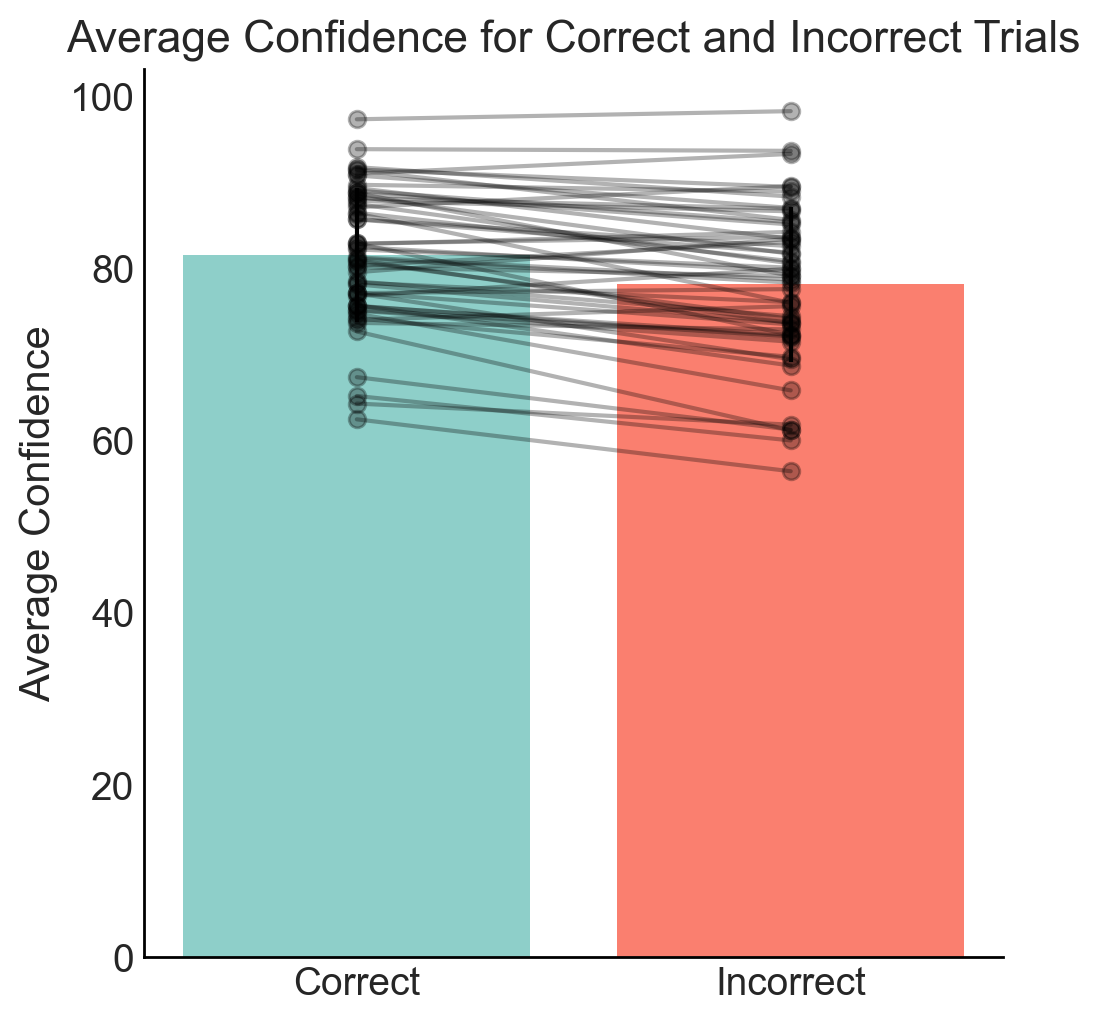

In [8]:
Subj_Confi_Cor_Incor = pd.DataFrame(columns=['Subj', 'Confidence', 'Correctness','Cor_Confi', 'Incor_Confi'])
for iS in range(0, len(Response_Acc_All)):
    Subj_Confi_Cor_Incor.loc[iS, 'Subj'] = iS+1
    Subj_Confi_Cor_Incor.loc[iS, 'Confidence'] = Response_Confi_All.iloc[iS, :].mean()
    Subj_Confi_Cor_Incor.loc[iS, 'Correctness'] = Response_Acc_All.iloc[iS, :].mean()
    corr_idx = np.where(Response_Acc_All.iloc[iS, :] == 1)[0]
    incorr_idx = np.where(Response_Acc_All.iloc[iS, :] == 0)[0]
    Subj_Confi_Cor_Incor.loc[iS, 'Cor_Confi'] = Response_Confi_All.iloc[iS, corr_idx].mean()
    Subj_Confi_Cor_Incor.loc[iS, 'Incor_Confi'] = Response_Confi_All.iloc[iS, incorr_idx].mean()

# bar plot of average confidence for correct and incorrect trials
plt.figure(figsize=(5, 5))
plt.bar([0, 1], [Subj_Confi_Cor_Incor['Cor_Confi'].mean(), Subj_Confi_Cor_Incor['Incor_Confi'].mean()], color=[gr, re])
plt.errorbar([0, 1], [Subj_Confi_Cor_Incor['Cor_Confi'].mean(), Subj_Confi_Cor_Incor['Incor_Confi'].mean()],
                yerr=[Subj_Confi_Cor_Incor['Cor_Confi'].std(), Subj_Confi_Cor_Incor['Incor_Confi'].std()],
                fmt='none', color='k')
# draw individual data points
for iS in range(0, len(Response_Acc_All)):
    plt.plot([0, 1], [Subj_Confi_Cor_Incor.loc[iS, 'Cor_Confi'], Subj_Confi_Cor_Incor.loc[iS, 'Incor_Confi']], 'o-', color='k', alpha=0.3)
plt.xticks([0, 1], ['Correct', 'Incorrect'])
plt.ylabel('Average Confidence')
plt.title('Average Confidence for Correct and Incorrect Trials')
plt.show()

# 2 Finding the CC and CW Questions

In this section, we do t-test to find trials that have mean accuracy significantly higher and lower than chance level. 

We then use the trials with significantly higher accuracy as CC questions and the trials with significantly lower accuracy as CW questions.

Because all questions are binary choice, we use a binomial test to find trials that have mean confidence significantly higher and lower than chance level. To prevent false positive, we use FDR correction to adjust the p-value.


In [9]:
from scipy.stats import binom_test
from statsmodels.stats.multitest import multipletests

# Question types: CC-Consensually Correct, CW-Consensually Wrong, Chance
Q_types = {'CC', 'CW', 'Chance'}
all_Q_types = []

# binomial test for each participant
pval = []
for iQ in range(1, total_question_number+1):
    pval.append(binom_test(Response_Acc_All.iloc[:, iQ-1].sum(), len(Response_Acc_All.iloc[:, iQ-1]), p=0.5))

# FDR correction
alpha = 0.05
reject, pval_corr = multipletests(pval, alpha=alpha, method='fdr_bh')[:2]

# assign question types
for iQ in range(1, total_question_number+1):
    if pval_corr[iQ-1] < alpha:
        if Response_Acc_All.iloc[:, iQ-1].mean() > 0.5:
            all_Q_types.append('CC')
        else:
            all_Q_types.append('CW')
    else:
        all_Q_types.append('Chance')
        
Mean_Accuracy_Test = pd.DataFrame({'Qidx': Qidx, 'Mean_Accuracy': Response_Acc_Mean, 'Mean_Confidence': Response_Confi_Mean, 'Q_type': all_Q_types})
Mean_Accuracy_Test.head()

print('The number of CC questions is: {}'.format(all_Q_types.count('CC')))
CC_idx = np.where(np.array(all_Q_types) == 'CC')[0]
print('Index of CC questions: {}'.format(CC_idx+1))
print()
print('The number of CW questions is: {}'.format(all_Q_types.count('CW')))
CW_idx = np.where(np.array(all_Q_types) == 'CW')[0]
print('Index of CW questions: {}'.format(CW_idx+1))


The number of CC questions is: 39
Index of CC questions: [ 1  3  9 11 12 13 14 15 20 23 25 26 31 33 40 42 43 44 45 46 48 49 50 51
 52 56 57 58 60 62 63 67 69 71 75 77 79 81 83]

The number of CW questions is: 13
Index of CW questions: [19 22 27 35 36 37 38 39 47 53 55 68 76]


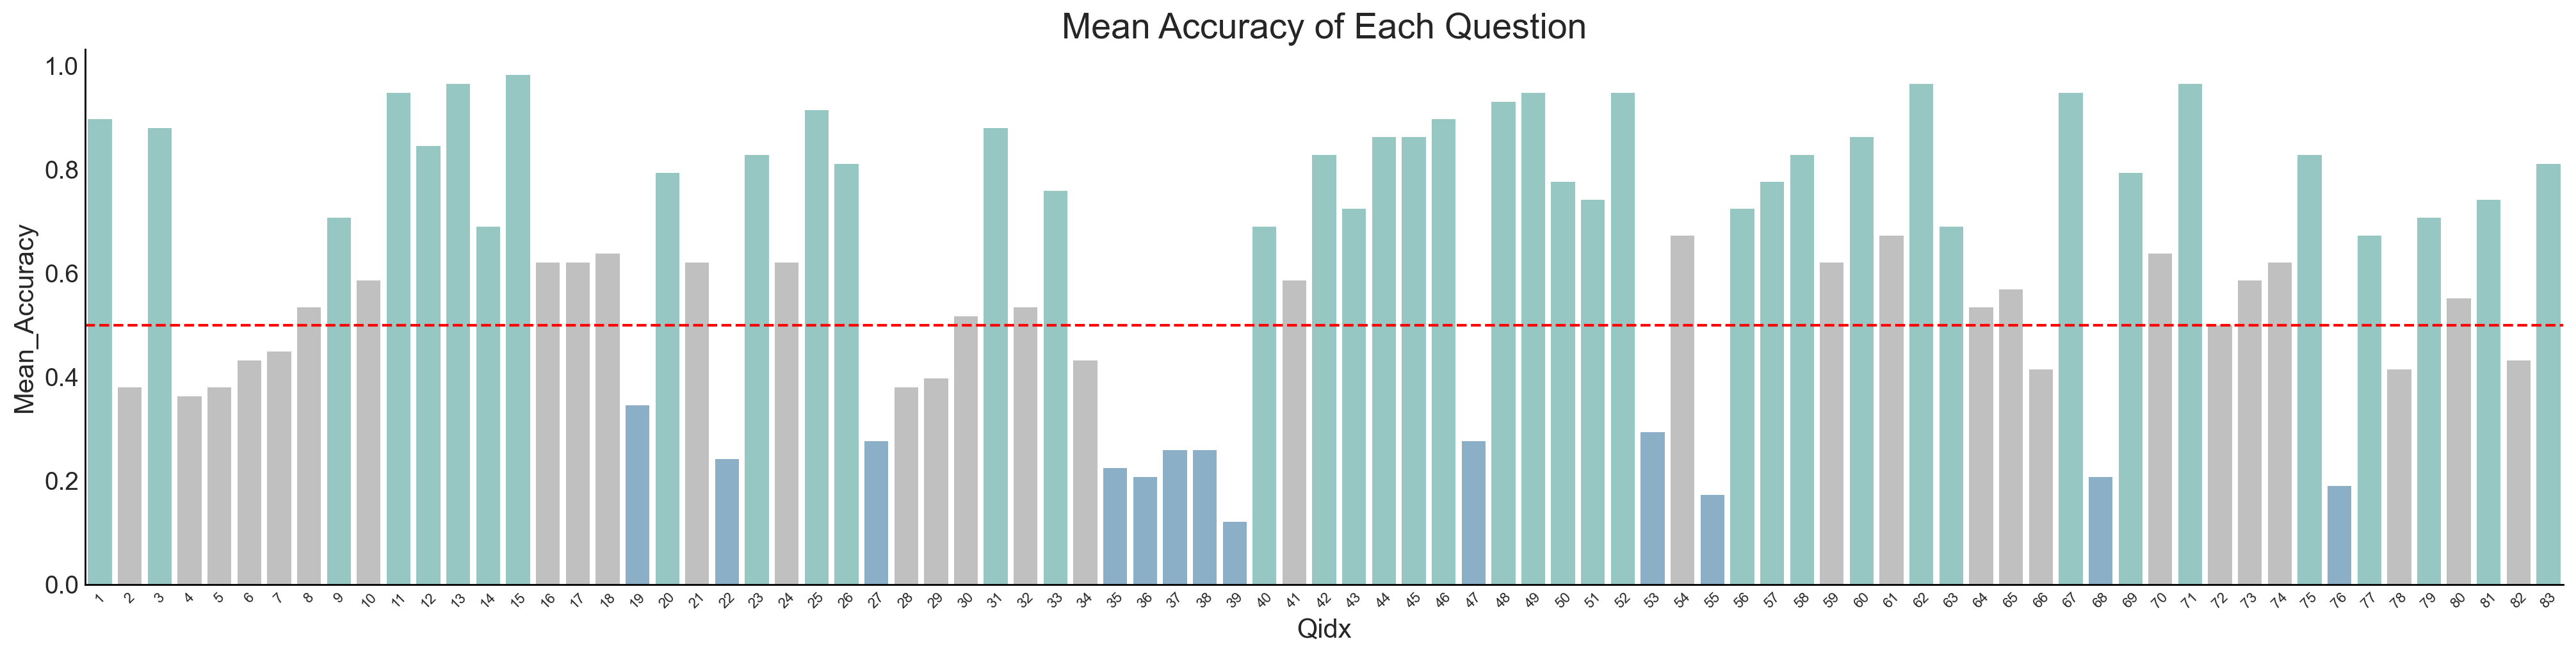

In [10]:
# visualize the data
# all the CC questions are colored gr, CW colored bl, and Chance colored sil

color_pallette = []
for i in range(1, total_question_number+1):
    if Mean_Accuracy_Test['Q_type'][i-1] == 'CC':
        color_pallette.append(gr)
    elif Mean_Accuracy_Test['Q_type'][i-1] == 'CW':
        color_pallette.append(bl)
    else:
        color_pallette.append(sil)

plt.figure(figsize=(20, 5))
sns.barplot(x='Qidx', y='Mean_Accuracy', data=Mean_Accuracy_Test, palette=color_pallette)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.xticks(rotation = 45, fontsize=8)
plt.title('Mean Accuracy of Each Question', fontsize=20)
plt.show()

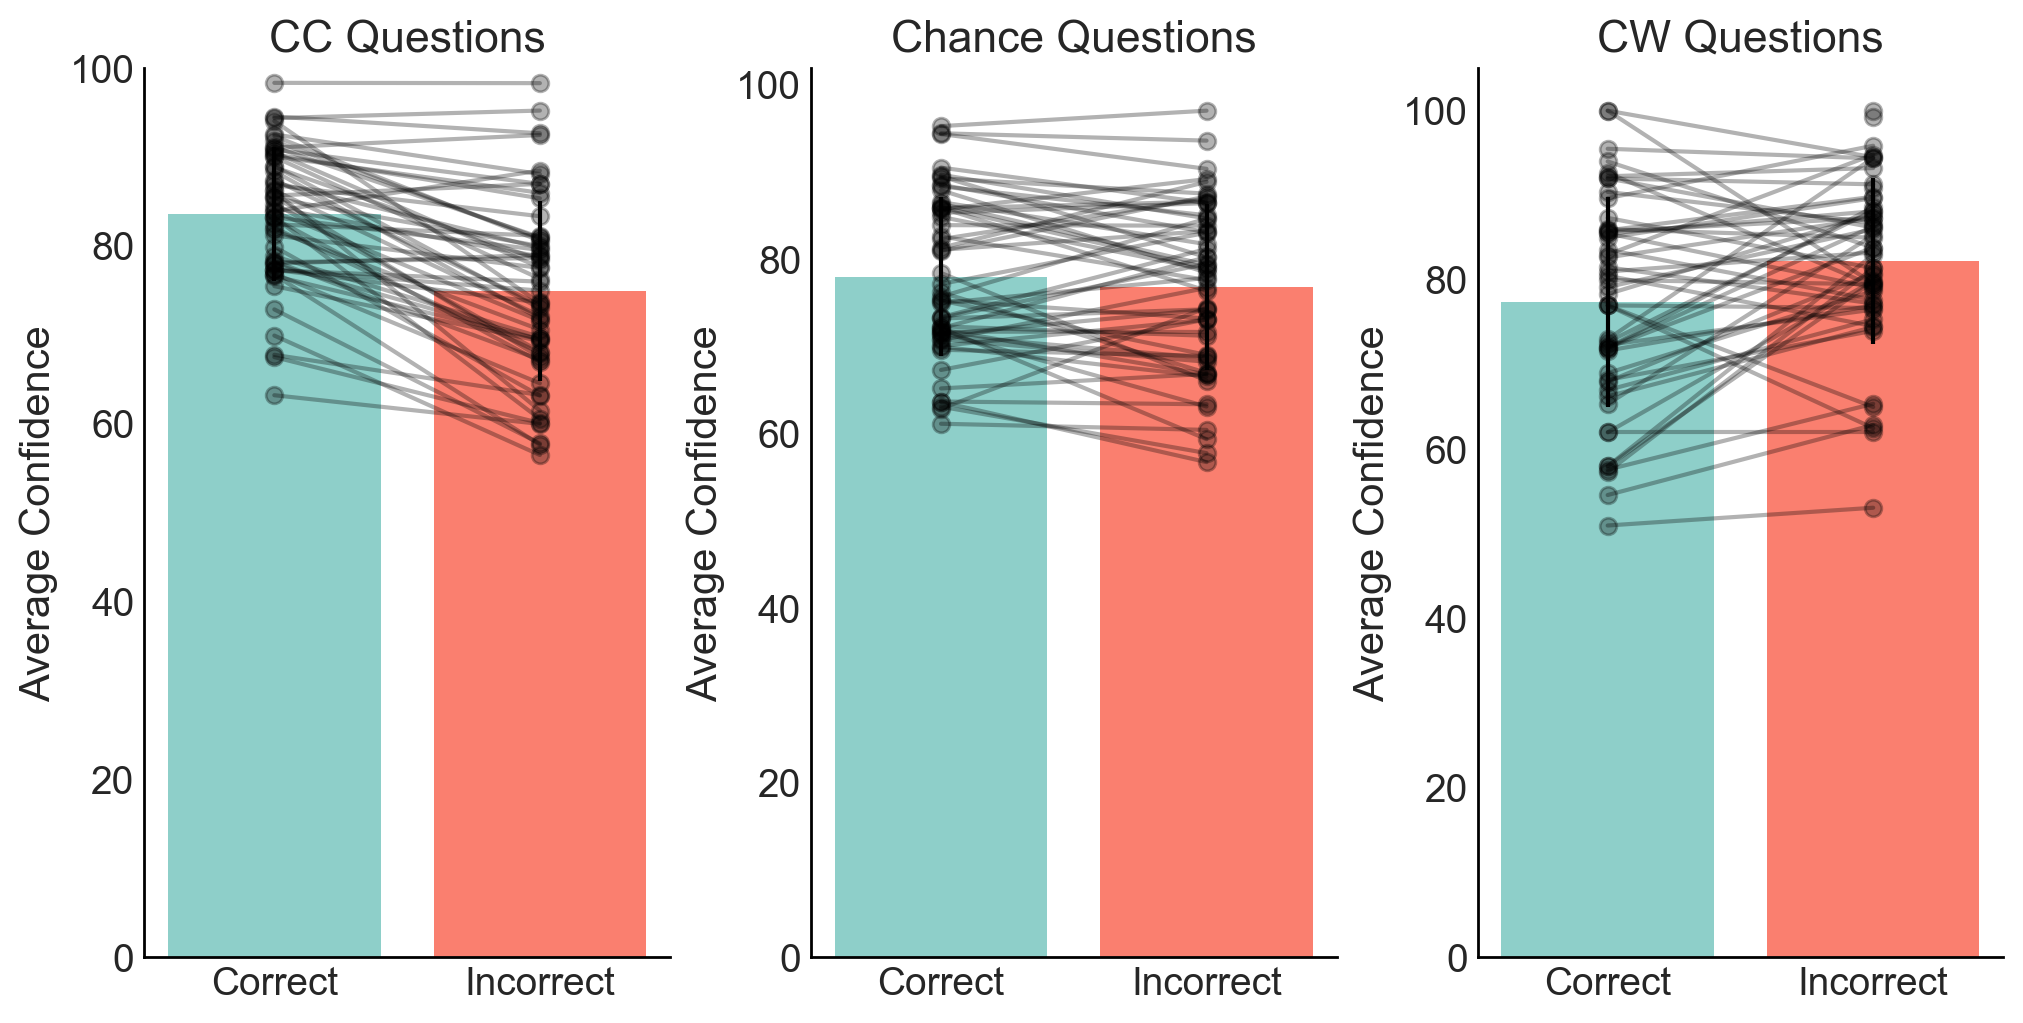

In [19]:
Subj_Confi_Cor_Incor = pd.DataFrame(columns=['Subj', 'CC_Cor_Confi', 'CW_Cor_Confi', 'Chance_Cor_Confi', 'CC_Incor_Confi', 'CW_Incor_Confi', 'Chance_Incor_Confi'])

for iS in range(0, len(Response_Acc_All)):
    Subj_Confi_Cor_Incor.loc[iS, 'Subj'] = iS+1
    corr_idx = np.where(Response_Acc_All.iloc[iS, :] == 1)[0]
    incorr_idx = np.where(Response_Acc_All.iloc[iS, :] == 0)[0]
    # CC_cor should be the average confidence of CC questions that are correct, the idx should be the intersection of CC_idx and corr_idx
    
    Subj_Confi_Cor_Incor.loc[iS, 'CC_Cor_Confi'] = Response_Confi_All.iloc[iS, np.intersect1d(CC_idx, corr_idx)].mean()
    Subj_Confi_Cor_Incor.loc[iS, 'CW_Cor_Confi'] = Response_Confi_All.iloc[iS, np.intersect1d(CW_idx, corr_idx)].mean()
    Subj_Confi_Cor_Incor.loc[iS, 'Chance_Cor_Confi'] = Response_Confi_All.iloc[iS, np.intersect1d(np.where(np.array(all_Q_types) == 'Chance')[0], corr_idx)].mean()
    Subj_Confi_Cor_Incor.loc[iS, 'CC_Incor_Confi'] = Response_Confi_All.iloc[iS, np.intersect1d(CC_idx, incorr_idx)].mean()
    Subj_Confi_Cor_Incor.loc[iS, 'CW_Incor_Confi'] = Response_Confi_All.iloc[iS, np.intersect1d(CW_idx, incorr_idx)].mean()
    Subj_Confi_Cor_Incor.loc[iS, 'Chance_Incor_Confi'] = Response_Confi_All.iloc[iS, np.intersect1d(np.where(np.array(all_Q_types) == 'Chance')[0], incorr_idx)].mean()
    

# bar plot of average confidence for correct and incorrect trials in CC, CW, and Chance questions
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.bar([0, 1], [Subj_Confi_Cor_Incor['CC_Cor_Confi'].mean(), Subj_Confi_Cor_Incor['CC_Incor_Confi'].mean()], color=[gr, re])
plt.errorbar([0, 1], [Subj_Confi_Cor_Incor['CC_Cor_Confi'].mean(), Subj_Confi_Cor_Incor['CC_Incor_Confi'].mean()],
                yerr=[Subj_Confi_Cor_Incor['CC_Cor_Confi'].std(), Subj_Confi_Cor_Incor['CC_Incor_Confi'].std()],
                fmt='none', color='k')
# draw individual data points
for iS in range(0, len(Response_Acc_All)):
    plt.plot([0, 1], [Subj_Confi_Cor_Incor.loc[iS, 'CC_Cor_Confi'], Subj_Confi_Cor_Incor.loc[iS, 'CC_Incor_Confi']], 'o-', color='k', alpha=0.3)
plt.xticks([0, 1], ['Correct', 'Incorrect'])
plt.ylabel('Average Confidence')
plt.title('CC Questions')
plt.ylim([0, 100])

plt.subplot(1, 3, 2)
plt.bar([0, 1], [Subj_Confi_Cor_Incor['Chance_Cor_Confi'].mean(), Subj_Confi_Cor_Incor['Chance_Incor_Confi'].mean()], color=[gr, re])
plt.errorbar([0, 1], [Subj_Confi_Cor_Incor['Chance_Cor_Confi'].mean(), Subj_Confi_Cor_Incor['Chance_Incor_Confi'].mean()],
                yerr=[Subj_Confi_Cor_Incor['Chance_Cor_Confi'].std(), Subj_Confi_Cor_Incor['Chance_Incor_Confi'].std()],
                fmt='none', color='k')
# draw individual data points
for iS in range(0, len(Response_Acc_All)):
    plt.plot([0, 1], [Subj_Confi_Cor_Incor.loc[iS, 'Chance_Cor_Confi'], Subj_Confi_Cor_Incor.loc[iS, 'Chance_Incor_Confi']], 'o-', color='k', alpha=0.3)
plt.xticks([0, 1], ['Correct', 'Incorrect'])
plt.ylabel('Average Confidence')
plt.title('Chance Questions')

plt.subplot(1, 3, 3)
plt.bar([0, 1], [Subj_Confi_Cor_Incor['CW_Cor_Confi'].mean(), Subj_Confi_Cor_Incor['CW_Incor_Confi'].mean()], color=[gr, re])
plt.errorbar([0, 1], [Subj_Confi_Cor_Incor['CW_Cor_Confi'].mean(), Subj_Confi_Cor_Incor['CW_Incor_Confi'].mean()],
                yerr=[Subj_Confi_Cor_Incor['CW_Cor_Confi'].std(), Subj_Confi_Cor_Incor['CW_Incor_Confi'].std()],
                fmt='none', color='k')
# draw individual data points
for iS in range(0, len(Response_Acc_All)):
    plt.plot([0, 1], [Subj_Confi_Cor_Incor.loc[iS, 'CW_Cor_Confi'], Subj_Confi_Cor_Incor.loc[iS, 'CW_Incor_Confi']], 'o-', color='k', alpha=0.3)
plt.xticks([0, 1], ['Correct', 'Incorrect'])
plt.ylabel('Average Confidence')
plt.title('CW Questions')

plt.show()

# 3. Confidence-Accuracy Relationship (No Normalization)

## 3.1 Correlation Analysis

In this section, we don't use the questions that have mean accuracy at around chance level, because the confidence-accuracy relationship is not clear for these questions.

Based on Self Consistency Model, **individual's confidence should be correlated with the population consensus**, which is a reflection of the common implict knowledge of the population.

In this section, we do the correlation analysis between the confidence and the consensus. For CC questions, we expect to see a positive correlation between the confidence and the consensus. For CW questions, the consensus is actually th wrong answer, so we expect to see a negative correlation between the confidence and the mean accuracy.

Or, we could flip the sign of the consensus for CW questions, and then we expect to see a positive correlation between the confidence and the consensus.


The correlation between consensus and confidence for CC questions is: PearsonRResult(statistic=0.4198874023954972, pvalue=0.00778792178156674)
The correlation between consensus and confidence for CW questions is: PearsonRResult(statistic=-0.04797803647612428, pvalue=0.8763131589669955)
The correlation between consensus and confidence for all questions is: PearsonRResult(statistic=0.36483552921383555, pvalue=0.00783126521912645)


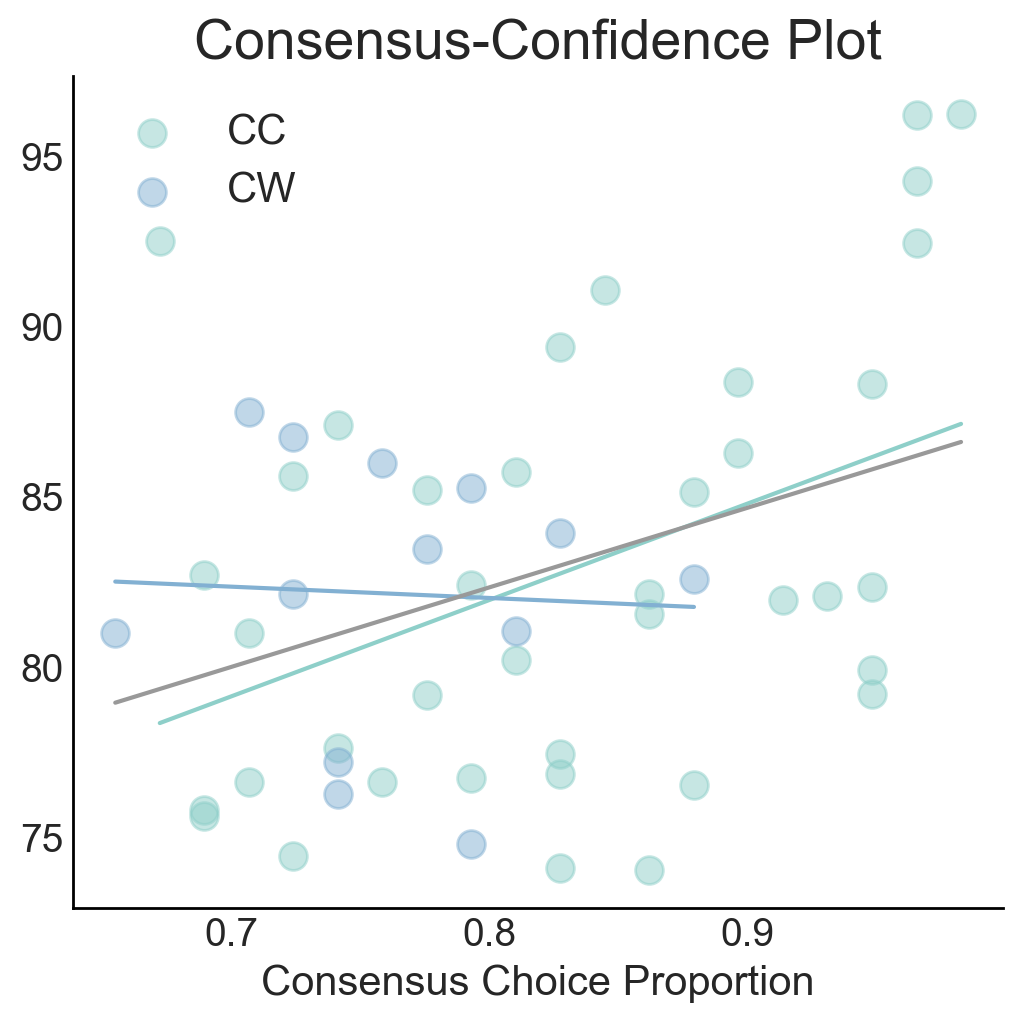

In [11]:
import scipy.stats as stats

Consensus_Confidence = pd.DataFrame({'Question': Qidx, 'Mean_Accuracy': Response_Acc_Mean, 'SD_Accuracy': Response_Acc_SD, 'Mean_Confidence': Response_Confi_Mean, 'SD_Confidence': Response_Confi_SD, 'Type': all_Q_types})
CC_Con_Con = Consensus_Confidence[Consensus_Confidence['Type'] == 'CC']
CC_Con_Con['Consensus'] = CC_Con_Con['Mean_Accuracy']
CW_Con_Con = Consensus_Confidence[Consensus_Confidence['Type'] == 'CW']
CW_Con_Con['Consensus'] = 1 - CW_Con_Con['Mean_Accuracy']
Avg_Con_Con = pd.concat([CC_Con_Con, CW_Con_Con], axis=0)

CC_Corr = stats.pearsonr(CC_Con_Con['Consensus'], CC_Con_Con['Mean_Confidence'])
CW_Corr = stats.pearsonr(CW_Con_Con['Consensus'], CW_Con_Con['Mean_Confidence'])
Avg_Con_Con_Corr = stats.pearsonr(Avg_Con_Con['Consensus'], Avg_Con_Con['Mean_Confidence'])

print('The correlation between consensus and confidence for CC questions is: {}'.format(CC_Corr))
print('The correlation between consensus and confidence for CW questions is: {}'.format(CW_Corr))
print('The correlation between consensus and confidence for all questions is: {}'.format(Avg_Con_Con_Corr))

# visualize the data

# Flip the accuracy in CW (1-x), and draw consensus-confidence plot
plt.figure(figsize=(5, 5))
plt.scatter(CC_Con_Con['Mean_Accuracy'], CC_Con_Con['Mean_Confidence'], c=gr, label='CC', alpha=0.5, s=100)
plt.scatter(1-CW_Con_Con['Mean_Accuracy'], CW_Con_Con['Mean_Confidence'], c=bl, label='CW', alpha=0.5, s=100)
plt.legend(fontsize=15)
# draw the line of best fit
plt.plot(np.unique(CC_Con_Con['Mean_Accuracy']), np.poly1d(np.polyfit(CC_Con_Con['Mean_Accuracy'], CC_Con_Con['Mean_Confidence'], 1))(np.unique(CC_Con_Con['Mean_Accuracy'])), c=gr)
plt.plot(np.unique(1-CW_Con_Con['Mean_Accuracy']), np.poly1d(np.polyfit(1-CW_Con_Con['Mean_Accuracy'], CW_Con_Con['Mean_Confidence'], 1))(np.unique(1-CW_Con_Con['Mean_Accuracy'])), c=bl)
plt.plot(np.unique(Avg_Con_Con['Consensus']), np.poly1d(np.polyfit(Avg_Con_Con['Consensus'], Avg_Con_Con['Mean_Confidence'], 1))(np.unique(Avg_Con_Con['Consensus'])), c=ak)
plt.xlabel('Consensus Choice Proportion', fontsize=15)
plt.title('Consensus-Confidence Plot', fontsize=20)
plt.show()



So, it appears that for CC questions, SCM hypothesis is supported. For CW questions, the SCM hypothesis is not supported.


## 3.2 Maximum Confidence Slating (MCS) Replication

In this section, we test the MCS model for joint decision.

It predicts:
- The joint decision is made by the subject who is more confident in their choice;
- For CC questions, the joint decision accracy is higher than the individual decision accuracy;
- For CW questions, the joint decision accracy is lower than the individual decision accuracy.

We test this on the whole **Q_list, CC and CW** trials separately.

In [12]:
def Dummy_HC(subj_1_choice, subj_1_confi, subj_2_choice, subj_2_confi):
    '''
    This function is used to simulate the joint decision based on MCS model for two subjects.
    AKA, generate the dummy subject's choice and confidence based on the choice with higher confidence.
    Input:
    subj_#_choice: the choice of subject #, 0 for wrong, 1 for right (for all questions)
    subj_#_confi: the confidence of subject #, range from 50 to 100
    
    Output:
    joint_choice: the joint decision of the two subjects, 0 for wrong, 1 for right (for all questions)
    joint_confi: the confidence of the joint decision, range from 50 to 100
    performance: if the joint decision accuarcy is lower than both, 0; if the joint decision accuarcy is higher than both, 1; if the joint decision accuarcy is higher than one but lower than the other, 0.5
    '''
    joint_choice = []
    joint_confi = []
    
    for i in range(len(subj_1_choice)):
        joint_confi.append(max(subj_1_confi[i], subj_2_confi[i]))
        if subj_1_choice[i] == subj_2_choice[i]:
            joint_choice.append(subj_1_choice[i])
        else:
            if subj_1_confi[i] > subj_2_confi[i]:
                joint_choice.append(subj_1_choice[i])
            elif subj_1_confi[i] < subj_2_confi[i]:
                joint_choice.append(subj_2_choice[i])
            else:
                joint_choice.append(np.random.choice([subj_1_choice[i], subj_2_choice[i]]))
    
    acc = np.mean(joint_choice)
    if acc < np.min([np.mean(subj_1_choice), np.mean(subj_2_choice)]):
        performance = 0 
    elif acc > np.max([np.mean(subj_1_choice), np.mean(subj_2_choice)]):
        performance = 1
    else:
        performance = 0.5
    
    return joint_choice, joint_confi, performance
                
def Dummy_LC(subj_1_choice, subj_1_confi, subj_2_choice, subj_2_confi):
    '''
    Conditional control, generate the dummy subject's choice and confidence based on the choice with lower confidence.
    '''
    joint_choice = []
    joint_confi = []
    
    for i in range(len(subj_1_choice)):
        joint_confi.append(min(subj_1_confi[i], subj_2_confi[i]))
        if subj_1_choice[i] == subj_2_choice[i]:
            joint_choice.append(subj_1_choice[i])
        else:
            if subj_1_confi[i] < subj_2_confi[i]:
                joint_choice.append(subj_1_choice[i])
            elif subj_1_confi[i] > subj_2_confi[i]:
                joint_choice.append(subj_2_choice[i])
            else:
                joint_choice.append(np.random.choice([subj_1_choice[i], subj_2_choice[i]]))
    
    acc = np.mean(joint_choice)
    if acc < np.min([np.mean(subj_1_choice), np.mean(subj_2_choice)]):
        performance = 0 
    elif acc > np.max([np.mean(subj_1_choice), np.mean(subj_2_choice)]):
        performance = 1
    else:
        performance = 0.5
    
    return joint_choice, joint_confi, performance

def Dummy_random(subj_1_choice, subj_1_confi, subj_2_choice, subj_2_confi):
    '''
    Conditional control2, generate the dummy subject's choice and confidence based on random choice from the two alternatives.
    '''
    joint_choice = []
    joint_confi = []
    
    for i in range(len(subj_1_choice)):
        random_idx = np.random.choice([0, 1])
        joint_confi.append([subj_1_confi[i], subj_2_confi[i]][random_idx])
        joint_choice.append([subj_1_choice[i], subj_2_choice[i]][random_idx])
    
    acc = np.mean(joint_choice)
    if acc < np.min([np.mean(subj_1_choice), np.mean(subj_2_choice)]):
        performance = 0 
    elif acc > np.max([np.mean(subj_1_choice), np.mean(subj_2_choice)]):
        performance = 1
    else:
        performance = 0.5
    
    return joint_choice, joint_confi, performance
    

In [13]:
import numpy as np

def calculate_performance_matrix(all_subj_acc, all_subj_confi, dummy_function):
    subjnum = len(all_subj_acc)
    performance_matrix = np.zeros((subjnum, subjnum))
    avg_accuracy_matrix = np.zeros((subjnum, subjnum))

    for i in range(subjnum):
        for j in range(subjnum):
            if i != j:
                subj_1_choice = all_subj_acc.iloc[i, :]
                subj_1_confi = all_subj_confi.iloc[i, :]
                subj_2_choice = all_subj_acc.iloc[j, :]
                subj_2_confi = all_subj_confi.iloc[j, :]

                joint_choice, joint_confi, performance = dummy_function(
                    subj_1_choice, subj_1_confi, subj_2_choice, subj_2_confi
                )

                performance_matrix[i, j] = performance
                avg_accuracy_matrix[i, j] = np.mean(joint_choice)

    return performance_matrix, avg_accuracy_matrix


CC_All_Subj = Response_Acc_All.iloc[:, CC_idx]
CC_Confi_All_Subj = Response_Confi_All.iloc[:, CC_idx]
CW_All_Subj = Response_Acc_All.iloc[:, CW_idx]
CW_Confi_All_Subj = Response_Confi_All.iloc[:, CW_idx]

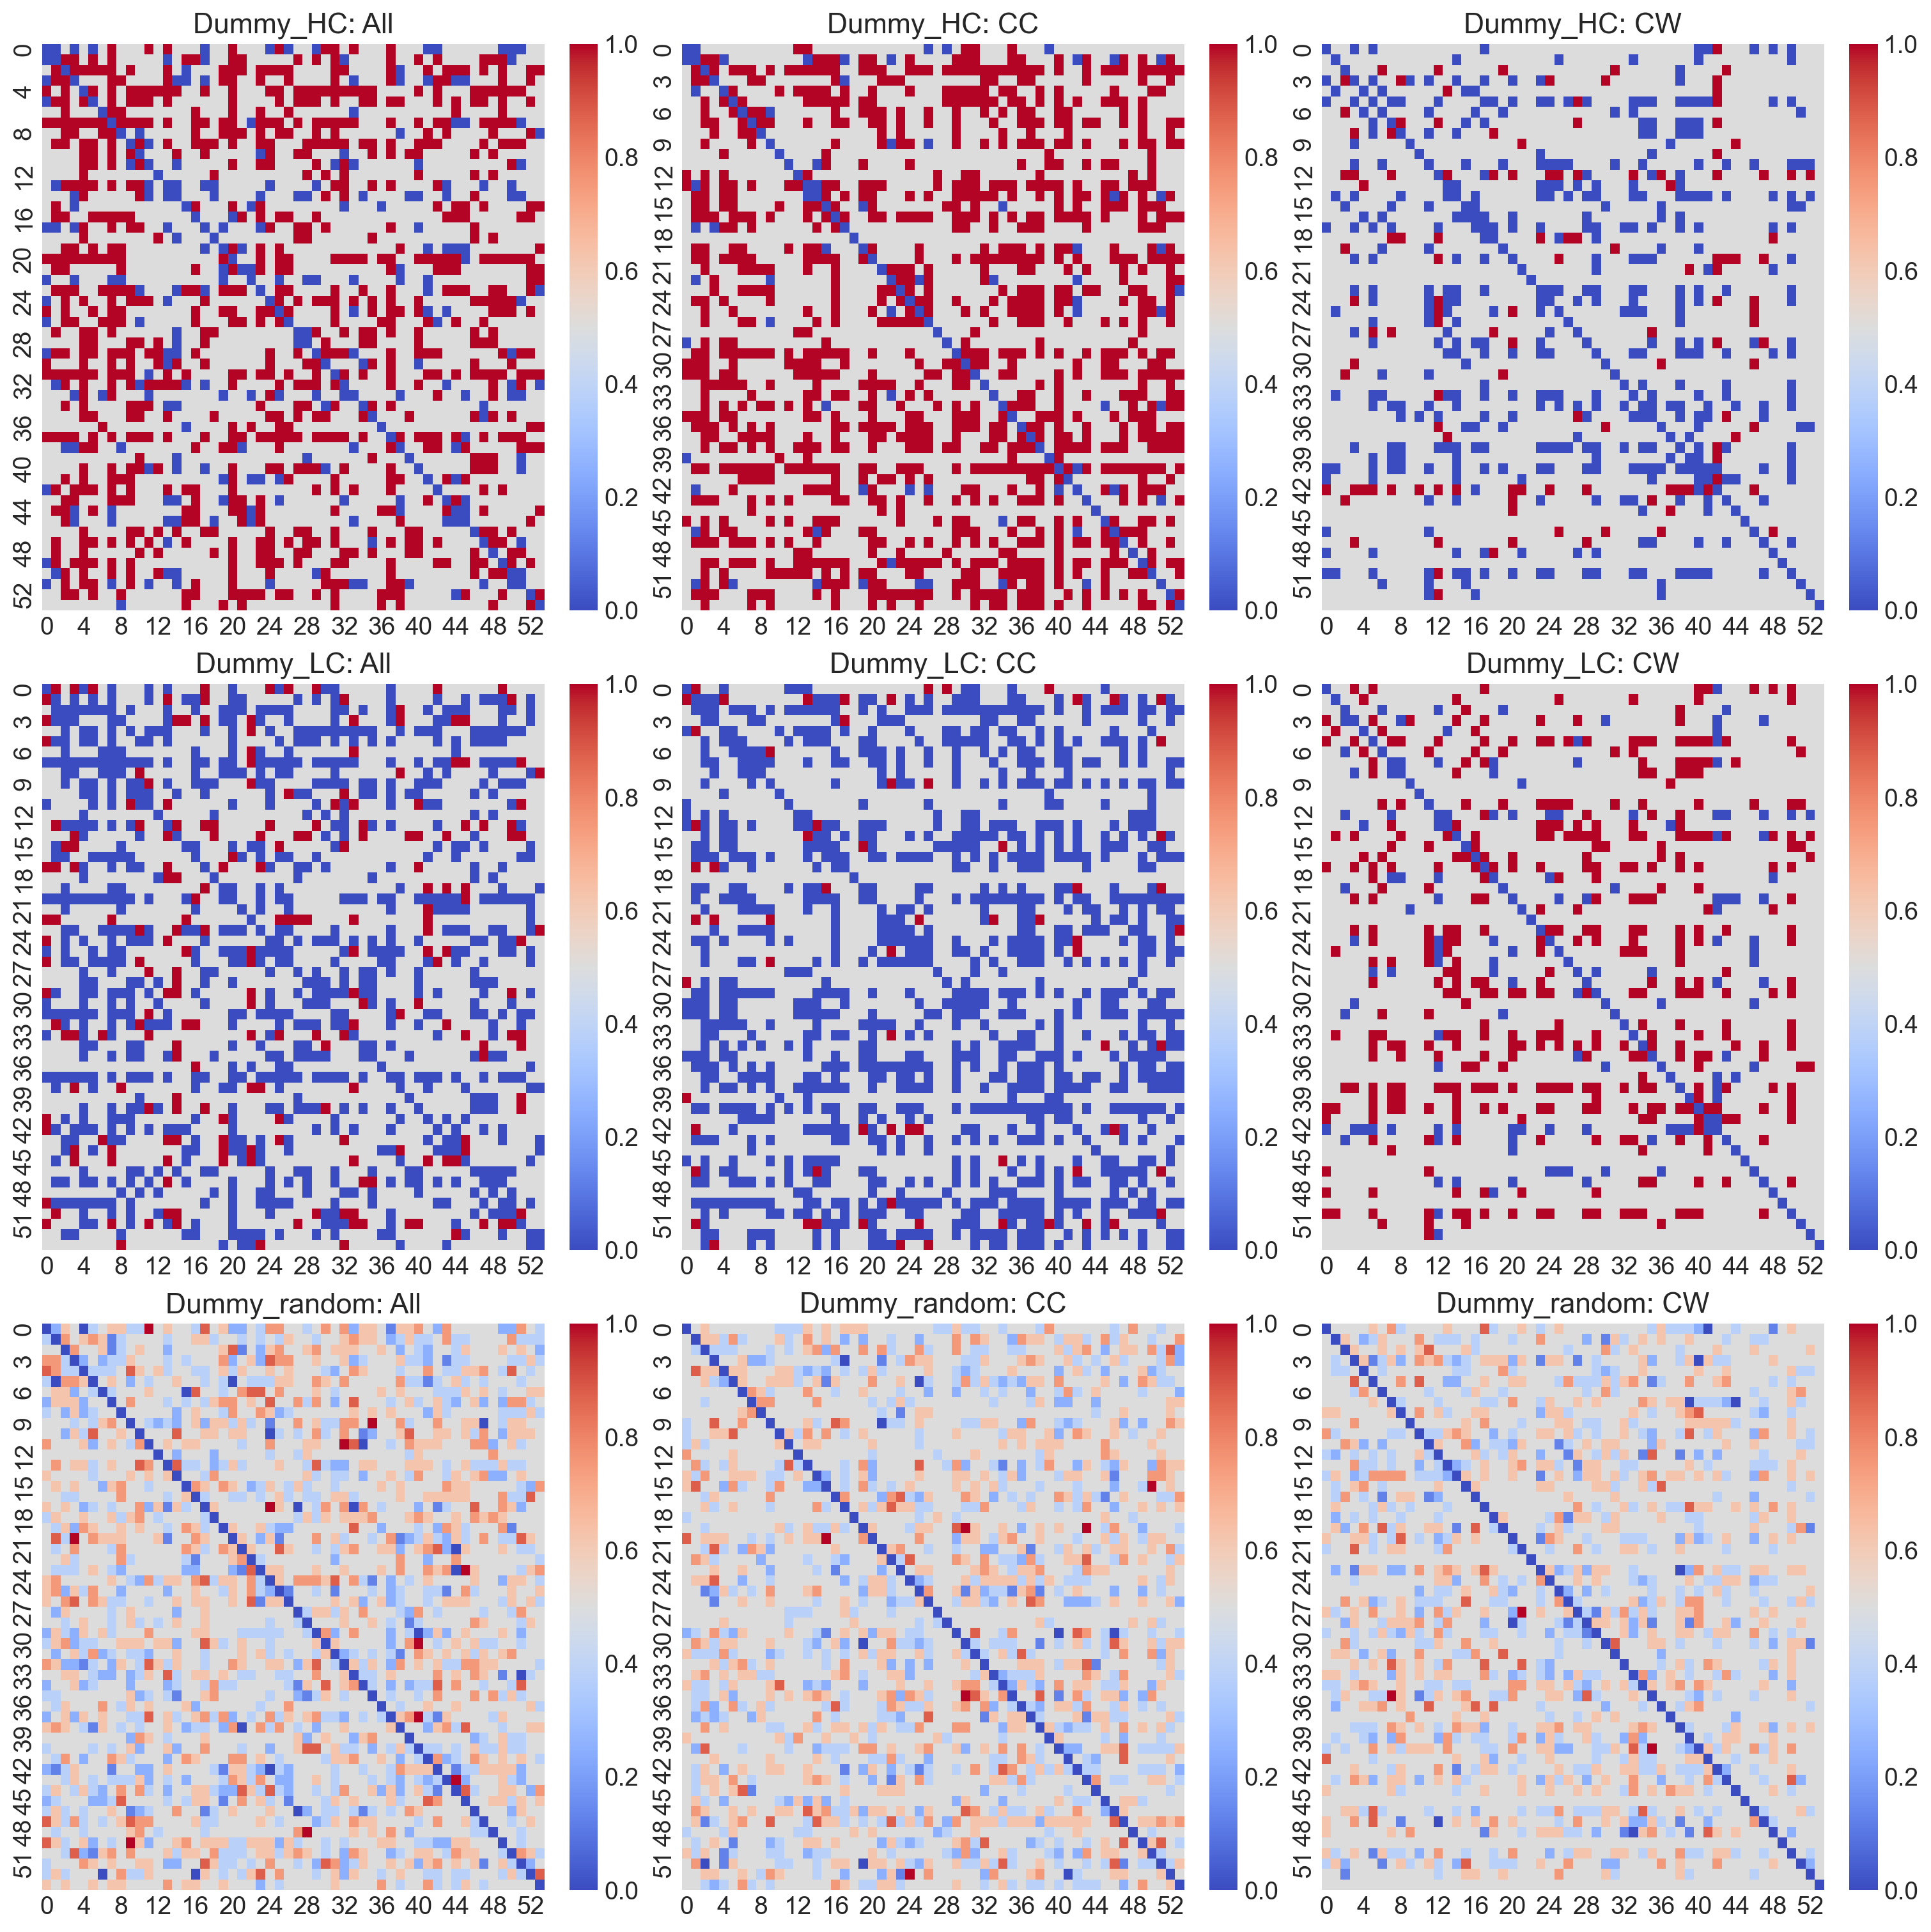

In [77]:
# calculate_performance_matrix for 3 methods, then visualize the results

funcs = [Dummy_HC, Dummy_LC, Dummy_random]
Q_types = ['All', 'CC', 'CW']
Q_data_choice = [Response_Acc_All, CC_All_Subj, CW_All_Subj]
Q_data_confi = [Response_Confi_All, CC_Confi_All_Subj, CW_Confi_All_Subj]
performance_matrix_dict = {}
avg_accuracy_matrix_dict = {}

rep_times = 4

for i in range(len(funcs)):
    for j in range(len(Q_types)):
        if i != 2:
            performance_matrix, avg_accuracy_matrix = calculate_performance_matrix(Q_data_choice[j], Q_data_confi[j], funcs[i])
        else:
            # for Dummy_random, we need to repeat the calculation for rep_times and take average
            performance_matrix = np.zeros((len(Q_data_choice[j]), len(Q_data_choice[j])))
            avg_accuracy_matrix = np.zeros((len(Q_data_choice[j]), len(Q_data_choice[j])))
            for k in range(rep_times):
                performance_matrix_temp, avg_accuracy_matrix_temp = calculate_performance_matrix(Q_data_choice[j], Q_data_confi[j], funcs[i])
                performance_matrix += performance_matrix_temp
                avg_accuracy_matrix += avg_accuracy_matrix_temp
            performance_matrix /= rep_times
            avg_accuracy_matrix /= rep_times
        temp_key = '{}_{}'.format(funcs[i].__name__, Q_types[j])
        performance_matrix_dict[temp_key] = performance_matrix
        avg_accuracy_matrix_dict[temp_key] = avg_accuracy_matrix
        

# visualize the results, plot row for 3 func, column for 3 types
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(len(funcs)):
    for j in range(len(Q_types)):
        temp_key = '{}_{}'.format(funcs[i].__name__, Q_types[j])
        sns.heatmap(performance_matrix_dict[temp_key], ax=ax[i, j], cmap='coolwarm', vmin=0, vmax=1)
        ax[i, j].set_title('{}: {}'.format(funcs[i].__name__, Q_types[j]))
plt.show()


In [14]:
All_avg_accuracy_matrix = avg_accuracy_matrix_dict['Dummy_HC_All']
CC_avg_accuracy_matrix = avg_accuracy_matrix_dict['Dummy_HC_CC']
CW_avg_accuracy_matrix = avg_accuracy_matrix_dict['Dummy_HC_CW']

# 2-sample test between all-subjects and MCS
from scipy import stats
print('All Question Accuracy: {} +/- {}'.format(np.mean(Response_Acc_All.mean(axis=1)), np.std(Response_Acc_All.mean(axis=1))))
print('MCS(Dummy-HC) All Question Accuracy: {} +/- {}'.format(np.mean(All_avg_accuracy_matrix), np.std(All_avg_accuracy_matrix)))
results = stats.ttest_ind(All_avg_accuracy_matrix.flatten(), Response_Acc_All.mean(axis=1))
print('t-test on all questions between MCS and all subjects: {}'.format(results))
print()
print('CC Question Accuracy: {} +/- {}'.format(np.mean(CC_All_Subj.mean(axis=1)), np.std(CC_All_Subj.mean(axis=1))))
print('MCS(Dummy-HC) CC Question Accuracy: {} +/- {}'.format(np.mean(CC_avg_accuracy_matrix), np.std(CC_avg_accuracy_matrix)))
results = stats.ttest_ind(CC_avg_accuracy_matrix.flatten(), CC_All_Subj.mean(axis=1))
print('t-test on CC between MCS and all subjects: {}'.format(results))
print()
print('CW Question Accuracy: {} +/- {}'.format(np.mean(CW_All_Subj.mean(axis=1)), np.std(CW_All_Subj.mean(axis=1))))
print('MCS(Dummy-HC) CW Question Accuracy: {} +/- {}'.format(np.mean(CW_avg_accuracy_matrix), np.std(CW_avg_accuracy_matrix)))
results = stats.ttest_ind(CW_avg_accuracy_matrix.flatten(), CW_All_Subj.mean(axis=1))
print('t-test on CW between MCS and all subjects: {}'.format(results))
      

NameError: name 'avg_accuracy_matrix_dict' is not defined

## 3.3 Pairing by matching accuracy level

In the original paper, it is stated:
> The results were analyzed as in Study 3. One participant, with the highest percent correct, was deleted. The remaining 40 participants
formed **20 dyads by matching the members of each dyad as closely as possible on percent correct**.

To fully replicate the original paper, we also do the same pairing method.

In [15]:
print('Valid Subject Number: {}'.format(len(Response_Acc_All)))

Valid Subject Number: 54


In [62]:
# Forming matching dyads based on the average accuracy
# rank the subjects based on their average accuracy
# Response_Acc_All = Response_Acc_All.reset_index(inplace=False)
# Response_Acc_All = Response_Acc_All.drop(['index'], axis=1, inplace=False)
subj_rank = Response_Acc_All.mean(axis=1).sort_values(ascending=False)
subj_rank = subj_rank.reset_index()
subj_rank.columns = ['Subj', 'Mean_Accuracy']
subj_rank['Rank'] = subj_rank.index + 1
subj_rank.head()
# form dyads based on the rank
dyads = []
for i in range(0, len(subj_rank), 2):
    dyads.append([subj_rank['Subj'][i], subj_rank['Subj'][i+1]])

For each dyad, we can have 4 types of performance mearsurement:
- *HP*: High performing, the one with higher accuracy;
- *LP*: Low performing, the one with lower accuracy;
- *D-HC*: Dummy high-confidence, the results from MCS algorithmn, Dummy_HC;
- *D-LC*: Dummy low-confidence, the results from Dummy_LC;

Additionally, we can have a control group, where the decision is made randomly without confidence in consideration:
- *D-random*: Dummy random selection.

We run on each dyads these slating algorithm on all questions, CC questions and CW questions.

In [65]:
# Template for all the dyads
Dyad_template = pd.DataFrame(columns=['Dyad','Subj_1', 'Subj_2', 'HC', 'LC', 'D-HC', 'D-LC', 'D-Random'])
rep_times = 5;

datas = [Response_Acc_All, CC_All_Subj, CW_All_Subj]
datas_confi = [Response_Confi_All, CC_Confi_All_Subj, CW_Confi_All_Subj]
Q_types = ['All', 'CC', 'CW']
all_dyads = {}

for iQ in range(len(Q_types)):
    data = datas[iQ]
    data_confi = datas_confi[iQ]
    key = Q_types[iQ]
    Dyads_data = Dyad_template.copy()
    for iD in range(len(dyads)):
        Dyad_i = Dyad_template.copy()
        Dyad_i.loc[iD, 'Dyad'] = iD+1
        subj_1, subj_2 = int(dyads[iD][0]), int(dyads[iD][1])
        Dyad_i.loc[iD, 'Subj_1'] = subj_1
        Dyad_i.loc[iD, 'Subj_2'] = subj_2
        Dyad_i.loc[iD, 'HC'] = np.max([data.iloc[subj_1, :].mean(), data.iloc[subj_2, :].mean()])
        Dyad_i.loc[iD, 'LC'] = np.min([data.iloc[subj_1, :].mean(), data.iloc[subj_2, :].mean()])
        Dyad_i.loc[iD, 'D-HC'] = np.mean(Dummy_HC(data.iloc[subj_1, :], data_confi.iloc[subj_1, :], data.iloc[subj_2, :], data_confi.iloc[subj_2, :])[0])
        Dyad_i.loc[iD, 'D-LC'] = np.mean(Dummy_LC(data.iloc[subj_1, :], data_confi.iloc[subj_1, :], data.iloc[subj_2, :], data_confi.iloc[subj_2, :])[0])
        random_acc = []
        for iR in range(rep_times):
            random_acc.append(np.mean(Dummy_random(data.iloc[subj_1, :], data_confi.iloc[subj_1, :], data.iloc[subj_2, :], data_confi.iloc[subj_2, :])[0]))
        Dyad_i.loc[iD, 'D-Random'] = np.mean(random_acc)
        Dyads_data = pd.concat([Dyads_data, Dyad_i], axis=0)
    all_dyads[key] = Dyads_data

In [77]:
print('Dyad data for all questions:')
print('Mean HC: {} +/- {}'.format(np.mean(all_dyads['All']['HC']), np.std(all_dyads['All']['HC'])))
print('Mean LC: {} +/- {}'.format(np.mean(all_dyads['All']['LC']), np.std(all_dyads['All']['LC'])))
print('Mean D-HC: {} +/- {}'.format(np.mean(all_dyads['All']['D-HC']), np.std(all_dyads['All']['D-HC'])))
print('Mean D-LC: {} +/- {}'.format(np.mean(all_dyads['All']['D-LC']), np.std(all_dyads['All']['D-LC'])))
print('Mean D-Random: {} +/- {}'.format(np.mean(all_dyads['All']['D-Random']), np.std(all_dyads['All']['D-Random'])))
print('D-HC higher than HC, t-test: {}'.format(stats.ttest_rel(all_dyads['All']['D-HC'], all_dyads['All']['HC'])))
print('D-HC higher than D-LC, t-test: {}'.format(stats.ttest_rel(all_dyads['All']['D-HC'], all_dyads['All']['D-LC'])))
print('D-HC better than HC: {} out of {}'.format(np.sum(all_dyads['All']['D-HC'] > all_dyads['All']['HC']), len(all_dyads['All'])))
print('Binomial test: {}'.format(binom_test(np.sum(all_dyads['All']['D-HC'] > all_dyads['All']['HC']), len(all_dyads['All']))))
print()

print('Dyad data for CC questions:')
print('Mean HC: {} +/- {}'.format(np.mean(all_dyads['CC']['HC']), np.std(all_dyads['CC']['HC'])))
print('Mean LC: {} +/- {}'.format(np.mean(all_dyads['CC']['LC']), np.std(all_dyads['CC']['LC'])))
print('Mean D-HC: {} +/- {}'.format(np.mean(all_dyads['CC']['D-HC']), np.std(all_dyads['CC']['D-HC'])))
print('Mean D-LC: {} +/- {}'.format(np.mean(all_dyads['CC']['D-LC']), np.std(all_dyads['CC']['D-LC'])))
print('Mean D-Random: {} +/- {}'.format(np.mean(all_dyads['CC']['D-Random']), np.std(all_dyads['CC']['D-Random'])))
print('D-HC higher than HC, t-test: {}'.format(stats.ttest_rel(all_dyads['CC']['D-HC'], all_dyads['CC']['HC'])))
print('D-HC higher than D-LC, t-test: {}'.format(stats.ttest_rel(all_dyads['CC']['D-HC'], all_dyads['CC']['D-LC'])))
print('D-HC better than HC: {} out of {}'.format(np.sum(all_dyads['CC']['D-HC'] > all_dyads['CC']['HC']), len(all_dyads['CC'])))
print('Binomial test: {}'.format(binom_test(np.sum(all_dyads['CC']['D-HC'] > all_dyads['CC']['HC']), len(all_dyads['CC']))))
print()

print('Dyad data for CW questions:')
print('Mean HC: {} +/- {}'.format(np.mean(all_dyads['CW']['HC']), np.std(all_dyads['CW']['HC'])))
print('Mean LC: {} +/- {}'.format(np.mean(all_dyads['CW']['LC']), np.std(all_dyads['CW']['LC'])))
print('Mean D-HC: {} +/- {}'.format(np.mean(all_dyads['CW']['D-HC']), np.std(all_dyads['CW']['D-HC'])))
print('Mean D-LC: {} +/- {}'.format(np.mean(all_dyads['CW']['D-LC']), np.std(all_dyads['CW']['D-LC'])))
print('Mean D-Random: {} +/- {}'.format(np.mean(all_dyads['CW']['D-Random']), np.std(all_dyads['CW']['D-Random'])))
print('D-HC lower than HC, t-test: {}'.format(stats.ttest_rel(all_dyads['CW']['D-HC'], all_dyads['CW']['HC'])))
print('D-HC lower than D-LC, t-test: {}'.format(stats.ttest_rel(all_dyads['CW']['D-HC'], all_dyads['CW']['D-LC'])))
print('D-HC worse than HC: {} out of {}'.format(np.sum(all_dyads['CW']['D-HC'] < all_dyads['CW']['HC']), len(all_dyads['CW'])))
print('Binomial test: {}'.format(binom_test(np.sum(all_dyads['CW']['D-HC'] < all_dyads['CW']['HC']), len(all_dyads['CW']))))
print()


Dyad data for all questions:
Mean HC: 0.6131191432396252 +/- 0.057392104712787176
Mean LC: 0.608210620258813 +/- 0.05519913120266916
Mean D-HC: 0.6251673360107094 +/- 0.06754739390384397
Mean D-LC: 0.5948237394020526 +/- 0.057280973823644075
Mean D-Random: 0.6092815707273539 +/- 0.05836693699689426
D-HC higher than HC, t-test: TtestResult(statistic=2.1078515067915813, pvalue=0.04483836501243893, df=26)
D-HC higher than D-LC, t-test: TtestResult(statistic=2.783413395023054, pvalue=0.009889610200647452, df=26)
D-HC better than HC: 15 out of 27
Binomial test: 0.7011080384254456

Dyad data for CC questions:
Mean HC: 0.8632478632478636 +/- 0.059215412224577
Mean LC: 0.7844254510921181 +/- 0.07227463472152117
Mean D-HC: 0.8641975308641979 +/- 0.0627355918895109
Mean D-LC: 0.7882241215574552 +/- 0.08035781880838055
Mean D-Random: 0.8248812915479585 +/- 0.06081729545536678
D-HC higher than HC, t-test: TtestResult(statistic=0.09232870714969661, pvalue=0.927144622359385, df=26)
D-HC higher than 

# 4. Confidence-Accuracy Relationship (Normalized Confidence)

Since confidence is relatively a rather subjective measure, we normalize the confidence for each subject, and then do the correlation analysis and modeling again.


In [79]:
# Normalize the subject's confidence across questions
def normalization(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

Norm_Response_Confi_All = Response_Confi_All.apply(normalization, axis=1)

## 4.1 Correlation Analysis

The correlation between consensus and confidence for CC questions is: PearsonRResult(statistic=0.41204889745269013, pvalue=0.009148404889913071)
The correlation between consensus and confidence for CW questions is: PearsonRResult(statistic=-0.06790338888546545, pvalue=0.8255498116775238)
The correlation between consensus and confidence for all questions is: PearsonRResult(statistic=0.3565166941353793, pvalue=0.00947995486446998)


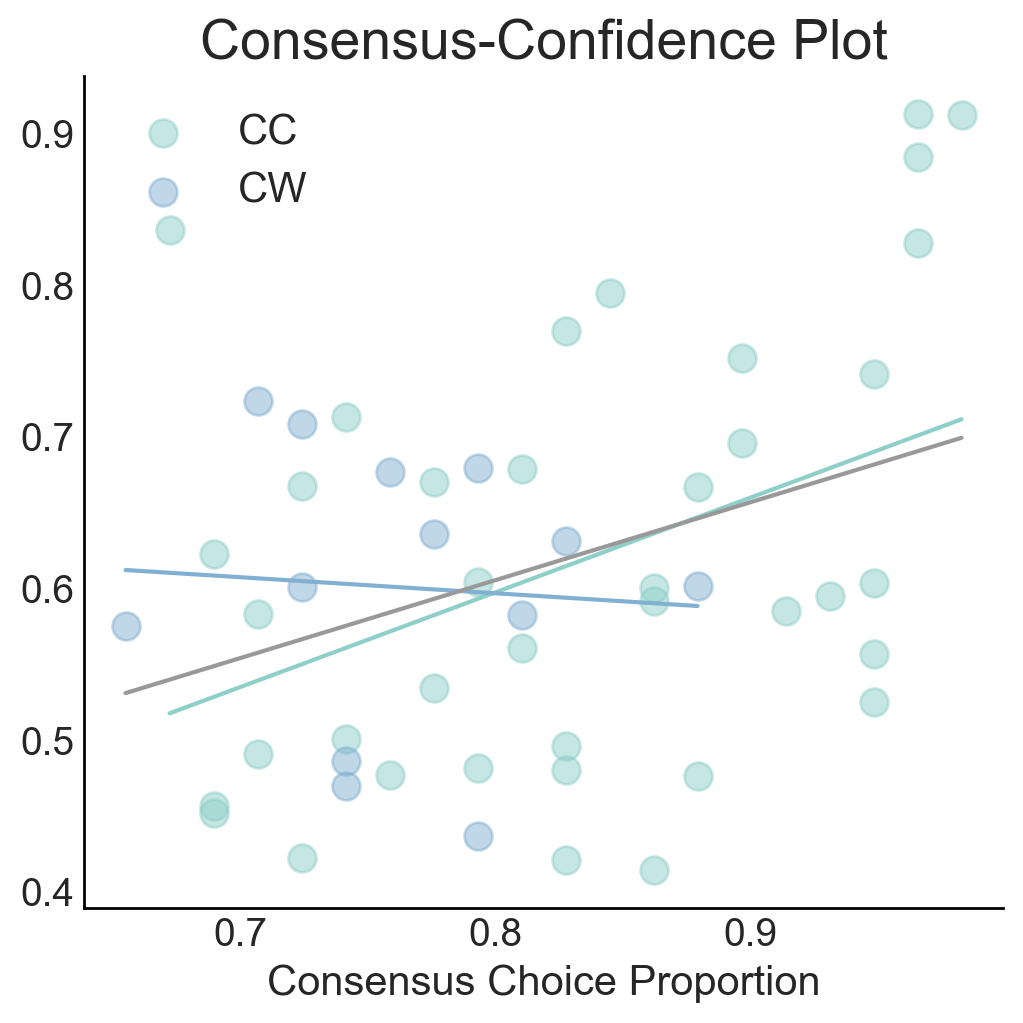

In [80]:
## Correlation between confidence and accuracy
import scipy.stats as stats

Consensus_Confidence = pd.DataFrame({'Question': Qidx, 'Mean_Accuracy': Response_Acc_Mean, 'SD_Accuracy': Response_Acc_SD, 'Mean_Confidence': Norm_Response_Confi_All.mean(axis=0), 'SD_Confidence': Norm_Response_Confi_All.std(axis=0), 'Type': all_Q_types})
CC_Con_Con = Consensus_Confidence[Consensus_Confidence['Type'] == 'CC']
CC_Con_Con['Consensus'] = CC_Con_Con['Mean_Accuracy']
CW_Con_Con = Consensus_Confidence[Consensus_Confidence['Type'] == 'CW']
CW_Con_Con['Consensus'] = 1 - CW_Con_Con['Mean_Accuracy']
Avg_Con_Con = pd.concat([CC_Con_Con, CW_Con_Con], axis=0)

CC_Corr = stats.pearsonr(CC_Con_Con['Consensus'], CC_Con_Con['Mean_Confidence'])
CW_Corr = stats.pearsonr(CW_Con_Con['Consensus'], CW_Con_Con['Mean_Confidence'])
Avg_Con_Con_Corr = stats.pearsonr(Avg_Con_Con['Consensus'], Avg_Con_Con['Mean_Confidence'])

print('The correlation between consensus and confidence for CC questions is: {}'.format(CC_Corr))
print('The correlation between consensus and confidence for CW questions is: {}'.format(CW_Corr))
print('The correlation between consensus and confidence for all questions is: {}'.format(Avg_Con_Con_Corr))

# visualize the data

# Flip the accuracy in CW (1-x), and draw consensus-confidence plot
plt.figure(figsize=(5, 5))
plt.scatter(CC_Con_Con['Mean_Accuracy'], CC_Con_Con['Mean_Confidence'], c=gr, label='CC', alpha=0.5, s=100)
plt.scatter(1-CW_Con_Con['Mean_Accuracy'], CW_Con_Con['Mean_Confidence'], c=bl, label='CW', alpha=0.5, s=100)
plt.legend(fontsize=15)
# draw the line of best fit
plt.plot(np.unique(CC_Con_Con['Mean_Accuracy']), np.poly1d(np.polyfit(CC_Con_Con['Mean_Accuracy'], CC_Con_Con['Mean_Confidence'], 1))(np.unique(CC_Con_Con['Mean_Accuracy'])), c=gr)
plt.plot(np.unique(1-CW_Con_Con['Mean_Accuracy']), np.poly1d(np.polyfit(1-CW_Con_Con['Mean_Accuracy'], CW_Con_Con['Mean_Confidence'], 1))(np.unique(1-CW_Con_Con['Mean_Accuracy'])), c=bl)
plt.plot(np.unique(Avg_Con_Con['Consensus']), np.poly1d(np.polyfit(Avg_Con_Con['Consensus'], Avg_Con_Con['Mean_Confidence'], 1))(np.unique(Avg_Con_Con['Consensus'])), c=ak)
plt.xlabel('Consensus Choice Proportion', fontsize=15)
plt.title('Consensus-Confidence Plot', fontsize=20)
plt.show()



## 4.2 Maximum Confidence Slating (MCS) Replication

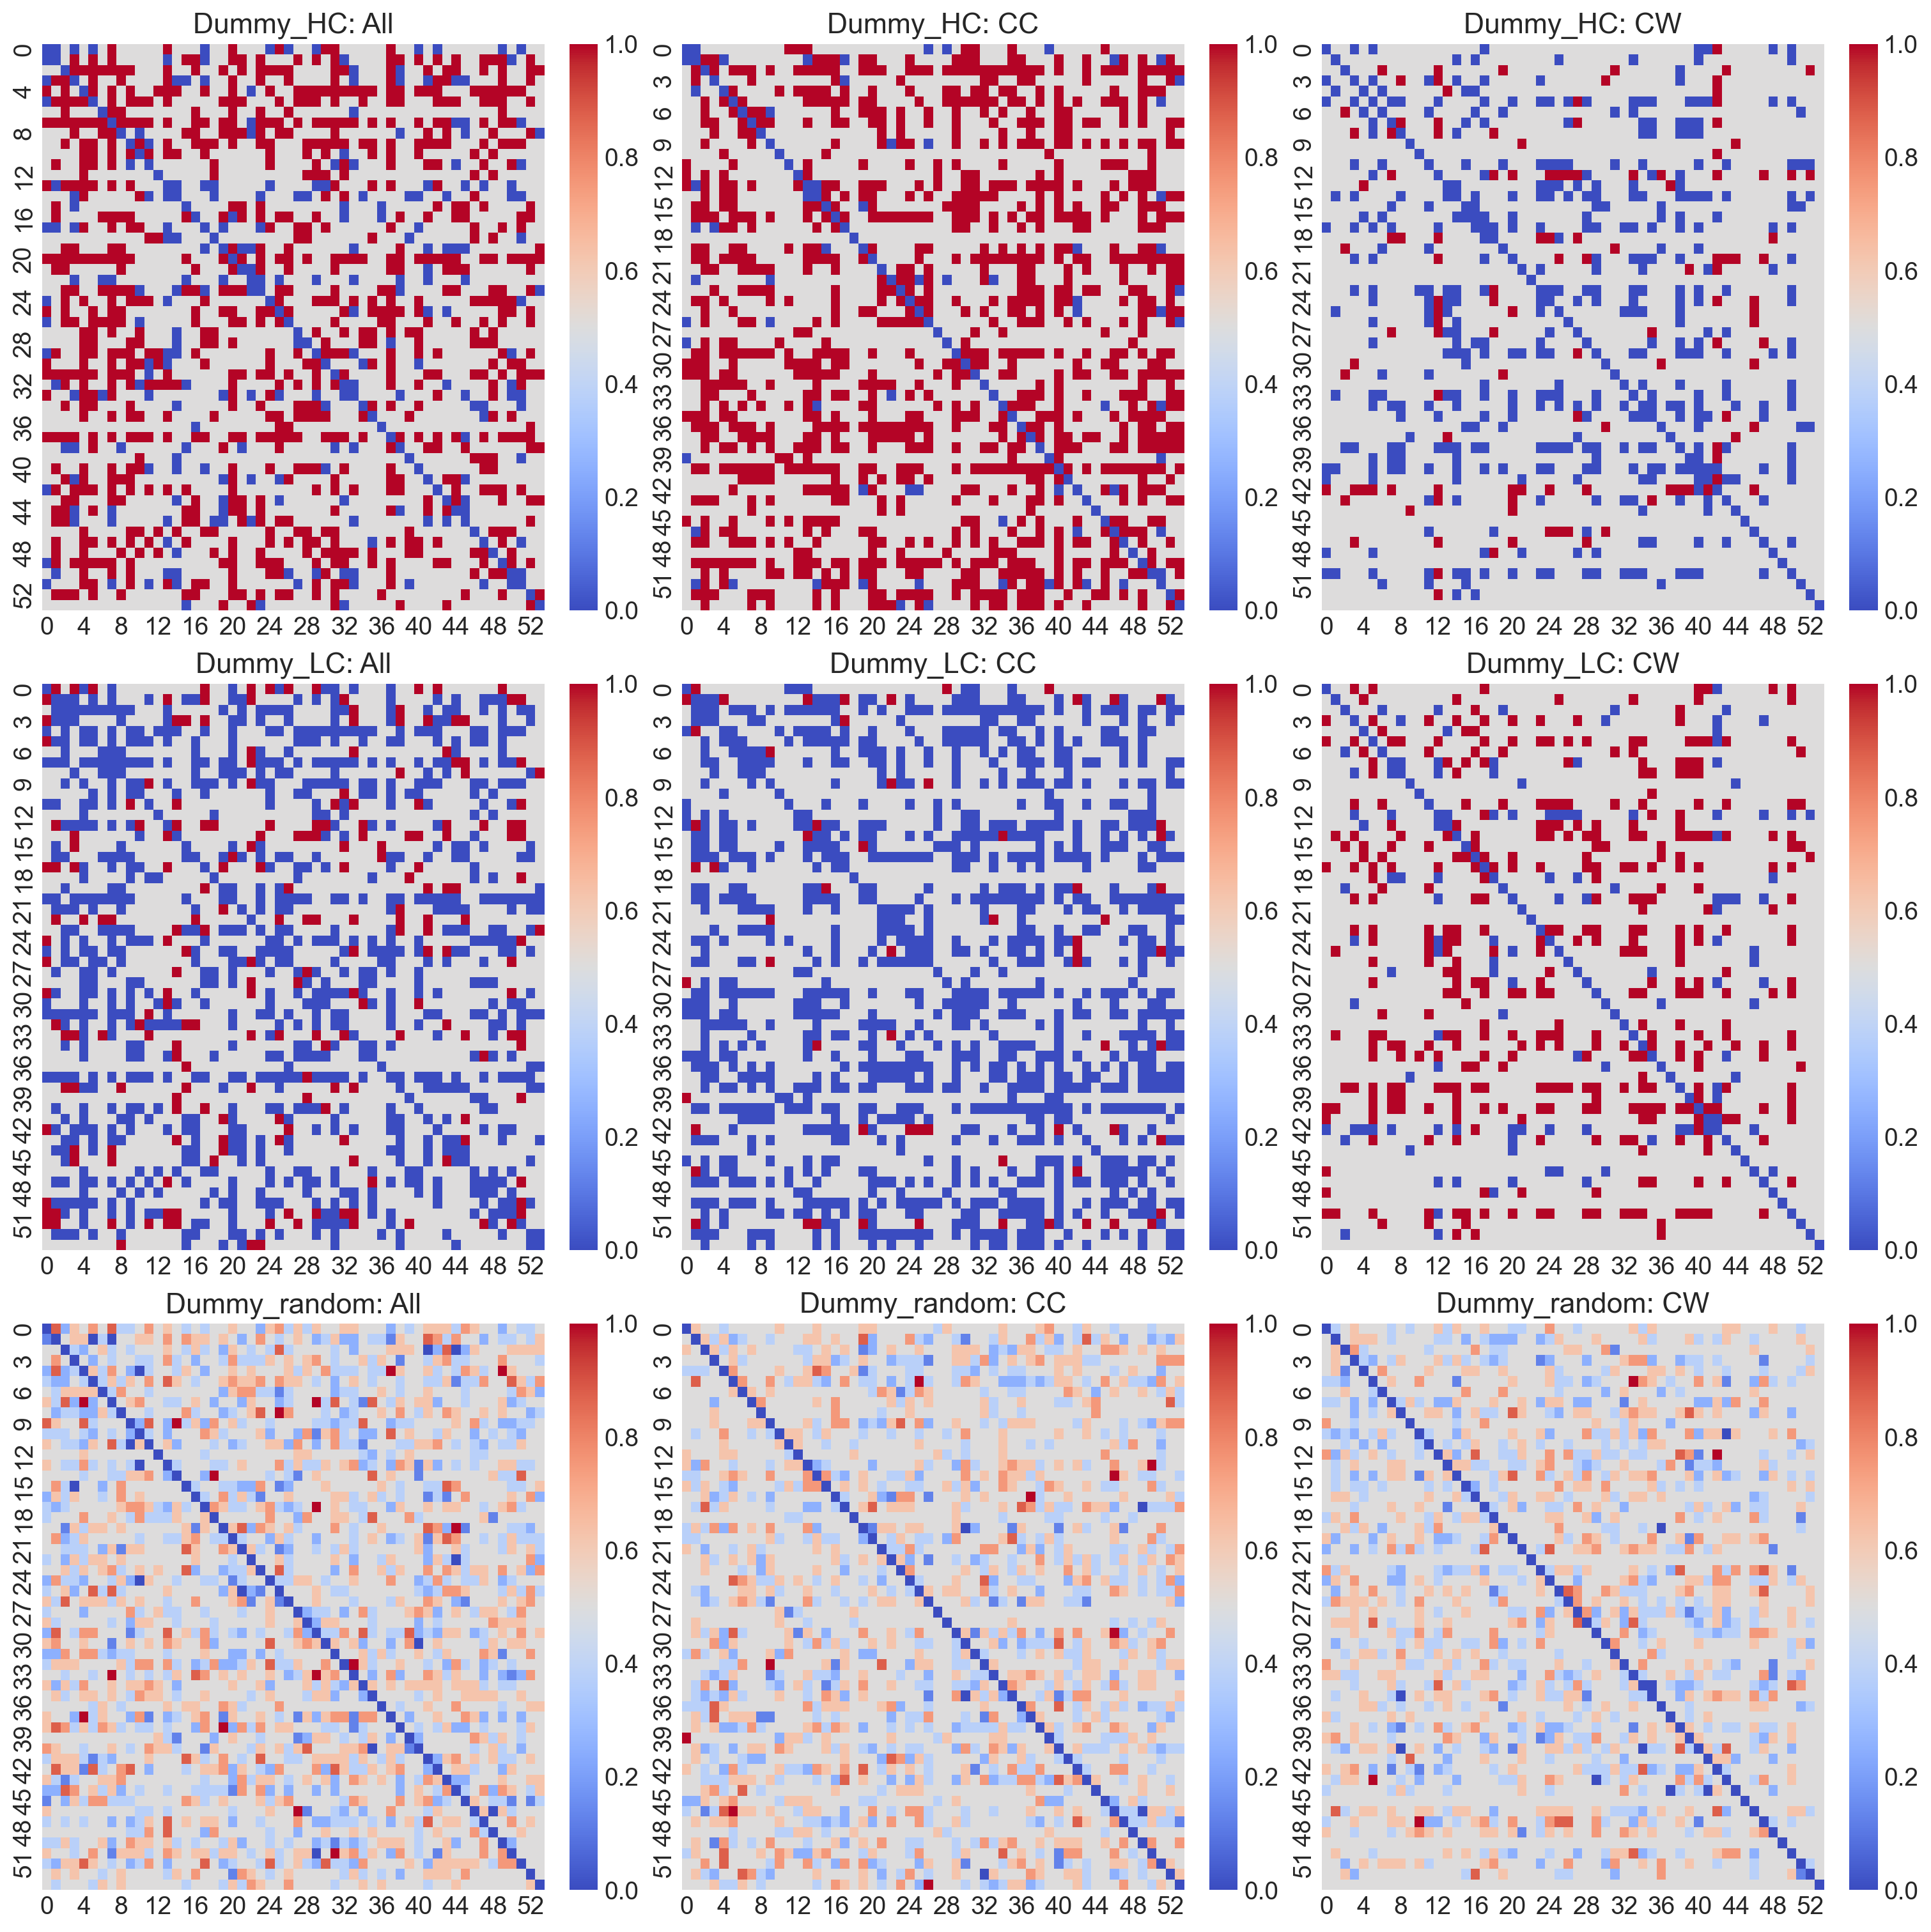

In [81]:
CC_All_Subj = Response_Acc_All.iloc[:, CC_idx]
Norm_CC_Confi_All_Subj = Norm_Response_Confi_All.iloc[:, CC_idx]
CW_All_Subj = Response_Acc_All.iloc[:, CW_idx]
Norm_CW_Confi_All_Subj = Norm_Response_Confi_All.iloc[:, CW_idx]

# calculate_performance_matrix for 3 methods, then visualize the results

funcs = [Dummy_HC, Dummy_LC, Dummy_random]
Q_types = ['All', 'CC', 'CW']
Q_data_choice = [Response_Acc_All, CC_All_Subj, CW_All_Subj]
Q_data_confi = [Response_Confi_All, CC_Confi_All_Subj, CW_Confi_All_Subj]
Norm_performance_matrix_dict = {}
Norm_avg_accuracy_matrix_dict = {}

rep_times = 4

for i in range(len(funcs)):
    for j in range(len(Q_types)):
        if i != 2:
            performance_matrix, avg_accuracy_matrix = calculate_performance_matrix(Q_data_choice[j], Q_data_confi[j], funcs[i])
        else:
            # for Dummy_random, we need to repeat the calculation for rep_times and take average
            performance_matrix = np.zeros((len(Q_data_choice[j]), len(Q_data_choice[j])))
            avg_accuracy_matrix = np.zeros((len(Q_data_choice[j]), len(Q_data_choice[j])))
            for k in range(rep_times):
                performance_matrix_temp, avg_accuracy_matrix_temp = calculate_performance_matrix(Q_data_choice[j], Q_data_confi[j], funcs[i])
                performance_matrix += performance_matrix_temp
                avg_accuracy_matrix += avg_accuracy_matrix_temp
            performance_matrix /= rep_times
            avg_accuracy_matrix /= rep_times
        temp_key = '{}_{}'.format(funcs[i].__name__, Q_types[j])
        Norm_performance_matrix_dict[temp_key] = performance_matrix
        Norm_avg_accuracy_matrix_dict[temp_key] = avg_accuracy_matrix
        

# visualize the results, plot row for 3 func, column for 3 types
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(len(funcs)):
    for j in range(len(Q_types)):
        temp_key = '{}_{}'.format(funcs[i].__name__, Q_types[j])
        sns.heatmap(Norm_performance_matrix_dict[temp_key], ax=ax[i, j], cmap='coolwarm', vmin=0, vmax=1)
        ax[i, j].set_title('{}: {}'.format(funcs[i].__name__, Q_types[j]))
plt.show()


In [82]:
Norm_All_avg_accuracy_matrix = Norm_avg_accuracy_matrix_dict['Dummy_HC_All']
Norm_CC_avg_accuracy_matrix = Norm_avg_accuracy_matrix_dict['Dummy_HC_CC']
Norm_CW_avg_accuracy_matrix = Norm_avg_accuracy_matrix_dict['Dummy_HC_CW']

# 2-sample test between all-subjects and MCS
from scipy import stats
print('All Question Accuracy: {} +/- {}'.format(np.mean(Response_Acc_All.mean(axis=1)), np.std(Response_Acc_All.mean(axis=1))))
print('MCS(Dummy-HC) Based on Normalized-Confi: {} +/- {}'.format(np.mean(Norm_All_avg_accuracy_matrix), np.std(Norm_All_avg_accuracy_matrix)))
results = stats.ttest_ind(Norm_All_avg_accuracy_matrix.flatten(), Response_Acc_All.mean(axis=1))
print('t-test on all questions between MCS and all subjects: {}'.format(results))
print()
print('CC Question Accuracy: {} +/- {}'.format(np.mean(CC_All_Subj.mean(axis=1)), np.std(CC_All_Subj.mean(axis=1))))
print('MCS(Dummy-HC) Based on Normalized-Confi: {} +/- {}'.format(np.mean(Norm_CC_avg_accuracy_matrix), np.std(Norm_CC_avg_accuracy_matrix)))
results = stats.ttest_ind(Norm_CC_avg_accuracy_matrix.flatten(), CC_All_Subj.mean(axis=1))
print('t-test on CC between MCS and all subjects: {}'.format(results))
print()
print('CW Question Accuracy: {} +/- {}'.format(np.mean(CW_All_Subj.mean(axis=1)), np.std(CW_All_Subj.mean(axis=1))))
print('MCS(Dummy-HC) Based on Normalized-Confi: {} +/- {}'.format(np.mean(Norm_CW_avg_accuracy_matrix), np.std(Norm_CW_avg_accuracy_matrix)))
results = stats.ttest_ind(Norm_CW_avg_accuracy_matrix.flatten(), CW_All_Subj.mean(axis=1))
print('t-test on CW between MCS and all subjects: {}'.format(results))
      

All Question Accuracy: 0.6106648817492192 +/- 0.0563597576636894
MCS(Dummy-HC) Based on Normalized-Confi: 0.6116771613201778 +/- 0.09964903996374098
t-test on all questions between MCS and all subjects: Ttest_indResult(statistic=0.07440385221066247, pvalue=0.9406940577314796)

CC Question Accuracy: 0.8238366571699904 +/- 0.07693040425631795
MCS(Dummy-HC) Based on Normalized-Confi: 0.8422408638458022 +/- 0.13251614600926148
t-test on CC between MCS and all subjects: Ttest_indResult(statistic=1.0170630378705956, pvalue=0.3092063407139713)

CW Question Accuracy: 0.21652421652421652 +/- 0.13411512587965607
MCS(Dummy-HC) Based on Normalized-Confi: 0.18259997889627522 +/- 0.12732013555745503
t-test on CW between MCS and all subjects: Ttest_indResult(statistic=-1.9375231925101415, pvalue=0.052776175915321494)


## 4.3 Pairing by matching accuracy level

In [83]:
# Template for all the dyads
Dyad_template = pd.DataFrame(columns=['Dyad','Subj_1', 'Subj_2', 'HC', 'LC', 'D-HC', 'D-LC', 'D-Random'])
rep_times = 5;

datas = [Response_Acc_All, CC_All_Subj, CW_All_Subj]
datas_confi = [Norm_Response_Confi_All, Norm_CC_Confi_All_Subj, Norm_CW_Confi_All_Subj]
Q_types = ['All', 'CC', 'CW']
Norm_all_dyads = {}

for iQ in range(len(Q_types)):
    data = datas[iQ]
    data_confi = datas_confi[iQ]
    key = Q_types[iQ]
    Dyads_data = Dyad_template.copy()
    for iD in range(len(dyads)):
        Dyad_i = Dyad_template.copy()
        Dyad_i.loc[iD, 'Dyad'] = iD+1
        subj_1, subj_2 = int(dyads[iD][0]), int(dyads[iD][1])
        Dyad_i.loc[iD, 'Subj_1'] = subj_1
        Dyad_i.loc[iD, 'Subj_2'] = subj_2
        Dyad_i.loc[iD, 'HC'] = np.max([data.iloc[subj_1, :].mean(), data.iloc[subj_2, :].mean()])
        Dyad_i.loc[iD, 'LC'] = np.min([data.iloc[subj_1, :].mean(), data.iloc[subj_2, :].mean()])
        Dyad_i.loc[iD, 'D-HC'] = np.mean(Dummy_HC(data.iloc[subj_1, :], data_confi.iloc[subj_1, :], data.iloc[subj_2, :], data_confi.iloc[subj_2, :])[0])
        Dyad_i.loc[iD, 'D-LC'] = np.mean(Dummy_LC(data.iloc[subj_1, :], data_confi.iloc[subj_1, :], data.iloc[subj_2, :], data_confi.iloc[subj_2, :])[0])
        random_acc = []
        for iR in range(rep_times):
            random_acc.append(np.mean(Dummy_random(data.iloc[subj_1, :], data_confi.iloc[subj_1, :], data.iloc[subj_2, :], data_confi.iloc[subj_2, :])[0]))
        Dyad_i.loc[iD, 'D-Random'] = np.mean(random_acc)
        Dyads_data = pd.concat([Dyads_data, Dyad_i], axis=0)
    Norm_all_dyads[key] = Dyads_data

print('Dyad data for all questions:')
print('Mean HC: {} +/- {}'.format(np.mean(Norm_all_dyads['All']['HC']), np.std(Norm_all_dyads['All']['HC'])))
print('Mean LC: {} +/- {}'.format(np.mean(Norm_all_dyads['All']['LC']), np.std(Norm_all_dyads['All']['LC'])))
print('Mean D-HC: {} +/- {}'.format(np.mean(Norm_all_dyads['All']['D-HC']), np.std(Norm_all_dyads['All']['D-HC'])))
print('Mean D-LC: {} +/- {}'.format(np.mean(Norm_all_dyads['All']['D-LC']), np.std(Norm_all_dyads['All']['D-LC'])))
print('D-HC higher than HC, t-test: {}'.format(stats.ttest_rel(Norm_all_dyads['All']['D-HC'], Norm_all_dyads['All']['HC'])))
print('D-HC higher than D-LC, t-test: {}'.format(stats.ttest_rel(Norm_all_dyads['All']['D-HC'], Norm_all_dyads['All']['D-LC'])))
print('D-HC better than HC: {} out of {}'.format(np.sum(Norm_all_dyads['All']['D-HC'] > Norm_all_dyads['All']['HC']), len(Norm_all_dyads['All'])))
print('Binomial test: {}'.format(binom_test(np.sum(Norm_all_dyads['All']['D-HC'] > Norm_all_dyads['All']['HC']), len(Norm_all_dyads['All']))))
print()

print('Dyad data for CC questions:')
print('Mean HC: {} +/- {}'.format(np.mean(Norm_all_dyads['CC']['HC']), np.std(Norm_all_dyads['CC']['HC'])))
print('Mean LC: {} +/- {}'.format(np.mean(Norm_all_dyads['CC']['LC']), np.std(Norm_all_dyads['CC']['LC'])))
print('Mean D-HC: {} +/- {}'.format(np.mean(Norm_all_dyads['CC']['D-HC']), np.std(Norm_all_dyads['CC']['D-HC'])))
print('Mean D-LC: {} +/- {}'.format(np.mean(Norm_all_dyads['CC']['D-LC']), np.std(Norm_all_dyads['CC']['D-LC'])))
print('D-HC higher than HC, t-test: {}'.format(stats.ttest_rel(Norm_all_dyads['CC']['D-HC'], Norm_all_dyads['CC']['HC'])))
print('D-HC higher than D-LC, t-test: {}'.format(stats.ttest_rel(Norm_all_dyads['CC']['D-HC'], Norm_all_dyads['CC']['D-LC'])))
print('D-HC better than HC: {} out of {}'.format(np.sum(Norm_all_dyads['CC']['D-HC'] > Norm_all_dyads['CC']['HC']), len(Norm_all_dyads['CC'])))
print('Binomial test: {}'.format(binom_test(np.sum(Norm_all_dyads['CC']['D-HC'] > Norm_all_dyads['CC']['HC']), len(Norm_all_dyads['CC']))))
print()

print('Dyad data for CW questions:')
print('Mean HC: {} +/- {}'.format(np.mean(Norm_all_dyads['CW']['HC']), np.std(Norm_all_dyads['CW']['HC'])))
print('Mean LC: {} +/- {}'.format(np.mean(Norm_all_dyads['CW']['LC']), np.std(Norm_all_dyads['CW']['LC'])))
print('Mean D-HC: {} +/- {}'.format(np.mean(Norm_all_dyads['CW']['D-HC']), np.std(Norm_all_dyads['CW']['D-HC'])))
print('Mean D-LC: {} +/- {}'.format(np.mean(Norm_all_dyads['CW']['D-LC']), np.std(Norm_all_dyads['CW']['D-LC'])))
print('D-HC lower than HC, t-test: {}'.format(stats.ttest_rel(Norm_all_dyads['CW']['D-HC'], Norm_all_dyads['CW']['HC'])))
print('D-HC lower than D-LC, t-test: {}'.format(stats.ttest_rel(Norm_all_dyads['CW']['D-HC'], Norm_all_dyads['CW']['D-LC'])))
print('D-HC worse than HC: {} out of {}'.format(np.sum(Norm_all_dyads['CW']['D-HC'] < Norm_all_dyads['CW']['HC']), len(Norm_all_dyads['CW'])))
print('Binomial test: {}'.format(binom_test(np.sum(Norm_all_dyads['CW']['D-HC'] < Norm_all_dyads['CW']['HC']), len(Norm_all_dyads['CW']))))
print()


Dyad data for all questions:
Mean HC: 0.6131191432396252 +/- 0.057392104712787176
Mean LC: 0.608210620258813 +/- 0.05519913120266916
Mean D-HC: 0.6233824185631414 +/- 0.06644473572667334
Mean D-LC: 0.5948237394020526 +/- 0.05811955432455132
D-HC higher than HC, t-test: TtestResult(statistic=1.8980014853930447, pvalue=0.06885125492743678, df=26)
D-HC higher than D-LC, t-test: TtestResult(statistic=2.7801841160204233, pvalue=0.009965351112882576, df=26)
D-HC better than HC: 13 out of 27
Binomial test: 1.0

Dyad data for CC questions:
Mean HC: 0.8632478632478636 +/- 0.059215412224577
Mean LC: 0.7844254510921181 +/- 0.07227463472152117
Mean D-HC: 0.861348528015195 +/- 0.05506434573342537
Mean D-LC: 0.7863247863247866 +/- 0.07548513560963972
D-HC higher than HC, t-test: TtestResult(statistic=-0.23826153477211737, pvalue=0.8135460750715757, df=26)
D-HC higher than D-LC, t-test: TtestResult(statistic=6.463595272887938, pvalue=7.527359661466011e-07, df=26)
D-HC better than HC: 13 out of 27
Bin

# X Save Progress

In [126]:
import dill
dill.dump_session('SCM_exp_1.db')